### 0.0 IMPORTS

In [3]:
import pandas as pd 
import inflection 
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing                import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
import seaborn as sns


from IPython.core.display                 import HTML
from IPython.display                      import Image

import scipy.stats as ss

import datetime

from tabulate import tabulate

from boruta import BorutaPy
from sklearn.ensemble                       import RandomForestRegressor

0.1 Helper fuctions

In [4]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    result_cramer = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    return result_cramer

0.2 Loading Data 

In [5]:
df_sales_raw = pd.read_csv('../base_dados/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../base_dados/store.csv', low_memory=False)
# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

### 1.0 Data Description

In [6]:
df1 = df_raw.copy()

cols_old = list(df1.columns)

### 1.1 Rename Columns 

In [7]:
snakecase = lambda x: inflection.underscore(x)

cols_rename = list(map(snakecase, cols_old))

df1.columns = cols_rename

### 1.2 Data Dimensions 

In [8]:

print('Number de Rows {} and Number de Columns {}'.format(df1.shape[0], df1.shape[1]))

Number de Rows 1017209 and Number de Columns 18


### 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA 

In [10]:
# checking NA values sum and its percentagem from total number of rows
missing_count = df1.isnull().sum() # the count of missing values
value_count = df1.isnull().count() # the count of all values

missing_percentage = round((missing_count/value_count) *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.00
day_of_week,0,0.00
date,0,0.00
sales,0,0.00
customers,0,0.00
open,0,0.00
promo,0,0.00
state_holiday,0,0.00
school_holiday,0,0.00
store_type,0,0.00


### 1.5 Fillout NA 

In [11]:
## competition_distance
df1['competition_distance'].max()

df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1).astype('int64')

# # ## competition_open_since_year	

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1).astype('int64')

# # promo2

# #'promo2_since_week' 

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

# # # promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)

# # # promo_interval

month_map = {1: 'Jan', 2: 'Feb' , 3:'Mar', 4: 'Apr', 5:'May' , 6: 'June', 7: 'Jul' , 8: 'Agu', 9: 'Sept' , 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace= True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if (x['month_map'] in x['promo_interval'].split(',')) else 0, axis = 1 )



### 1.6 Change types of data



In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 Descriptive Statistical  

In [13]:

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

cat_attributes.head()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
0,0,c,a,9,2008,31,2015,0,Jul
1,0,a,a,11,2007,13,2010,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,12,2006,14,2011,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,9,2009,31,2015,0,Jul
4,0,a,a,4,2015,31,2015,0,Jul


In [14]:
## Central Tendecy - mean, median 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersion -std, min, max , range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate 

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

#m.drop(m.iloc[:, 7:], inplace=True, axis=1)

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,promo2,0.00,1.00,1.00,0.50,1.00,0.50,-0.00,-2.00
9,is_promo,0.00,1.00,1.00,0.16,0.00,0.36,1.90,1.63


In [15]:
num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.93,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,promo2,0.00,1.00,1.00,0.50,1.00,0.50,-0.00,-2.00
9,is_promo,0.00,1.00,1.00,0.16,0.00,0.36,1.90,1.63


C:\Users\mathe\AppData\Local\Temp\ipykernel_1872\1060283804.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_open_since_year']);


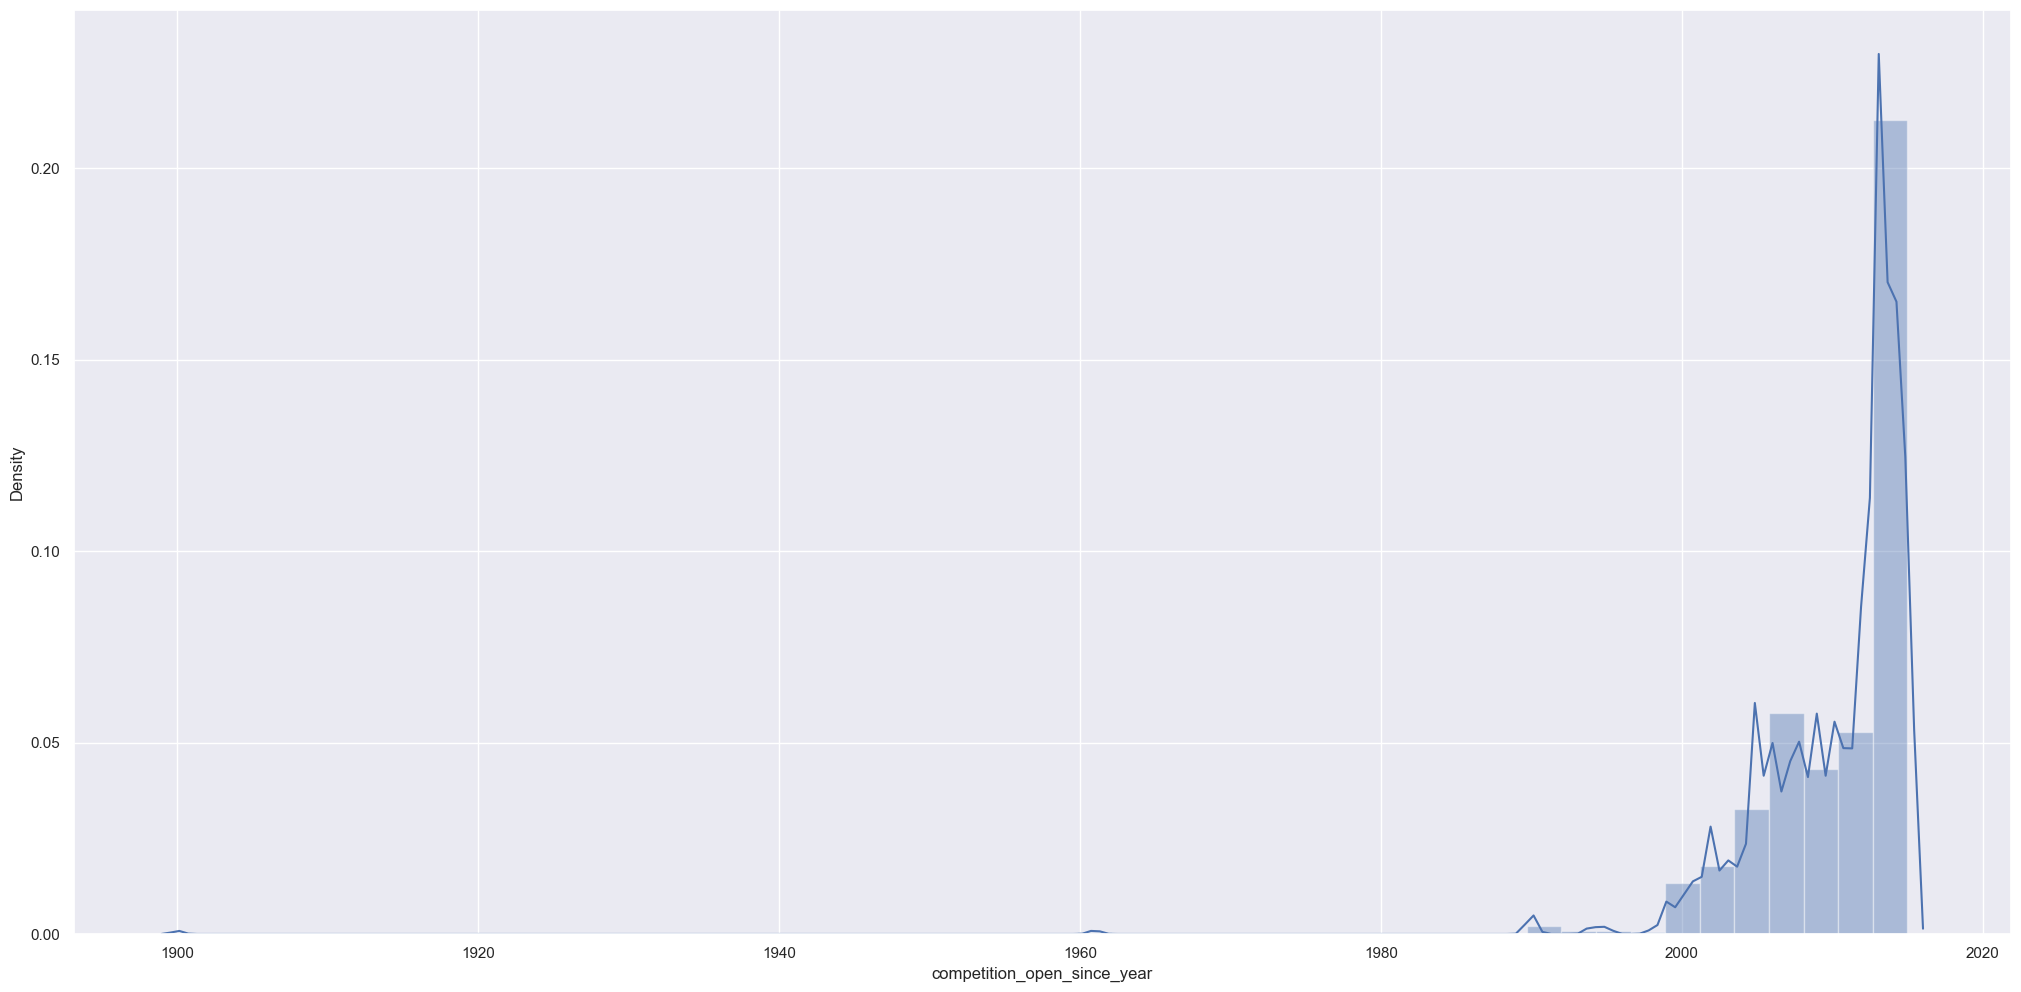

In [16]:
sns.distplot(df1['competition_open_since_year']);

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

### 1.7.2 Categorical Attributes

<AxesSubplot: xlabel='assortment', ylabel='sales'>

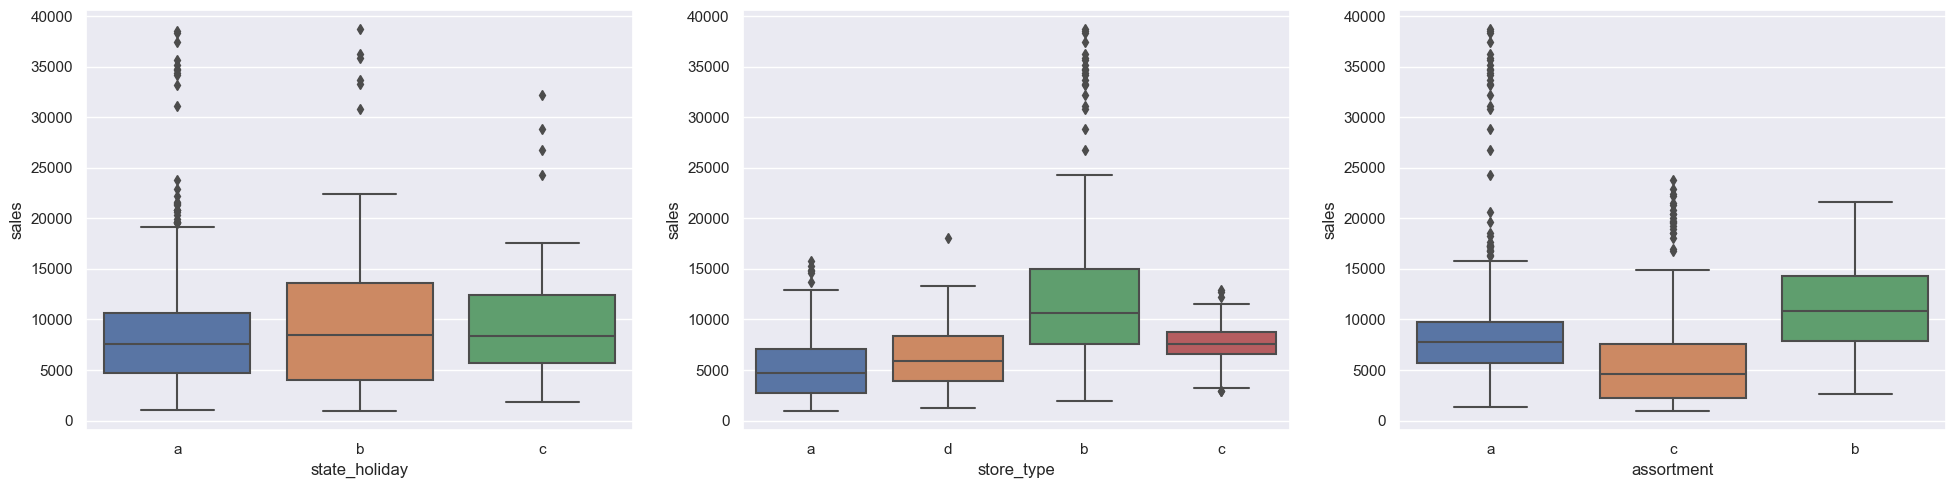

In [18]:
from matplotlib import gridspec
aux1 = df1.loc[((df1['state_holiday'] != '0') & (df1['sales'] > 0 )), :]

fig = plt.figure(figsize=(24, 12))
specs = gridspec.GridSpec( ncols=3, nrows=2, figure=fig )


ax1 = fig.add_subplot( specs[1, 0] ) # First Row First Column
ax2 = fig.add_subplot( specs[1, 1]) # Second Row First Column
ax3 = fig.add_subplot(specs[1,2]) # third row 

# plt.subplot(1,3,1)
# sns.boxplot(x = 'store_type', y= 'sales', data = aux1)

# plt.subplot(1,3,2)
# sns.boxenplot(x = 'store_type', y = 'sales', data = aux1)

# plt.subplot(1,3,3)
# sns.boxplot(x = 'assortment', y ='sales', data = aux1)





sns.boxplot(x = 'state_holiday' , y= 'sales' , data = aux1 , ax = ax1)


sns.boxplot(x = 'store_type' , y= 'sales' , data =  aux1 , ax =  ax2)


sns.boxplot( x = 'assortment', y = 'sales', data = aux1 , ax = ax3)



## 2.0 Passo 02 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

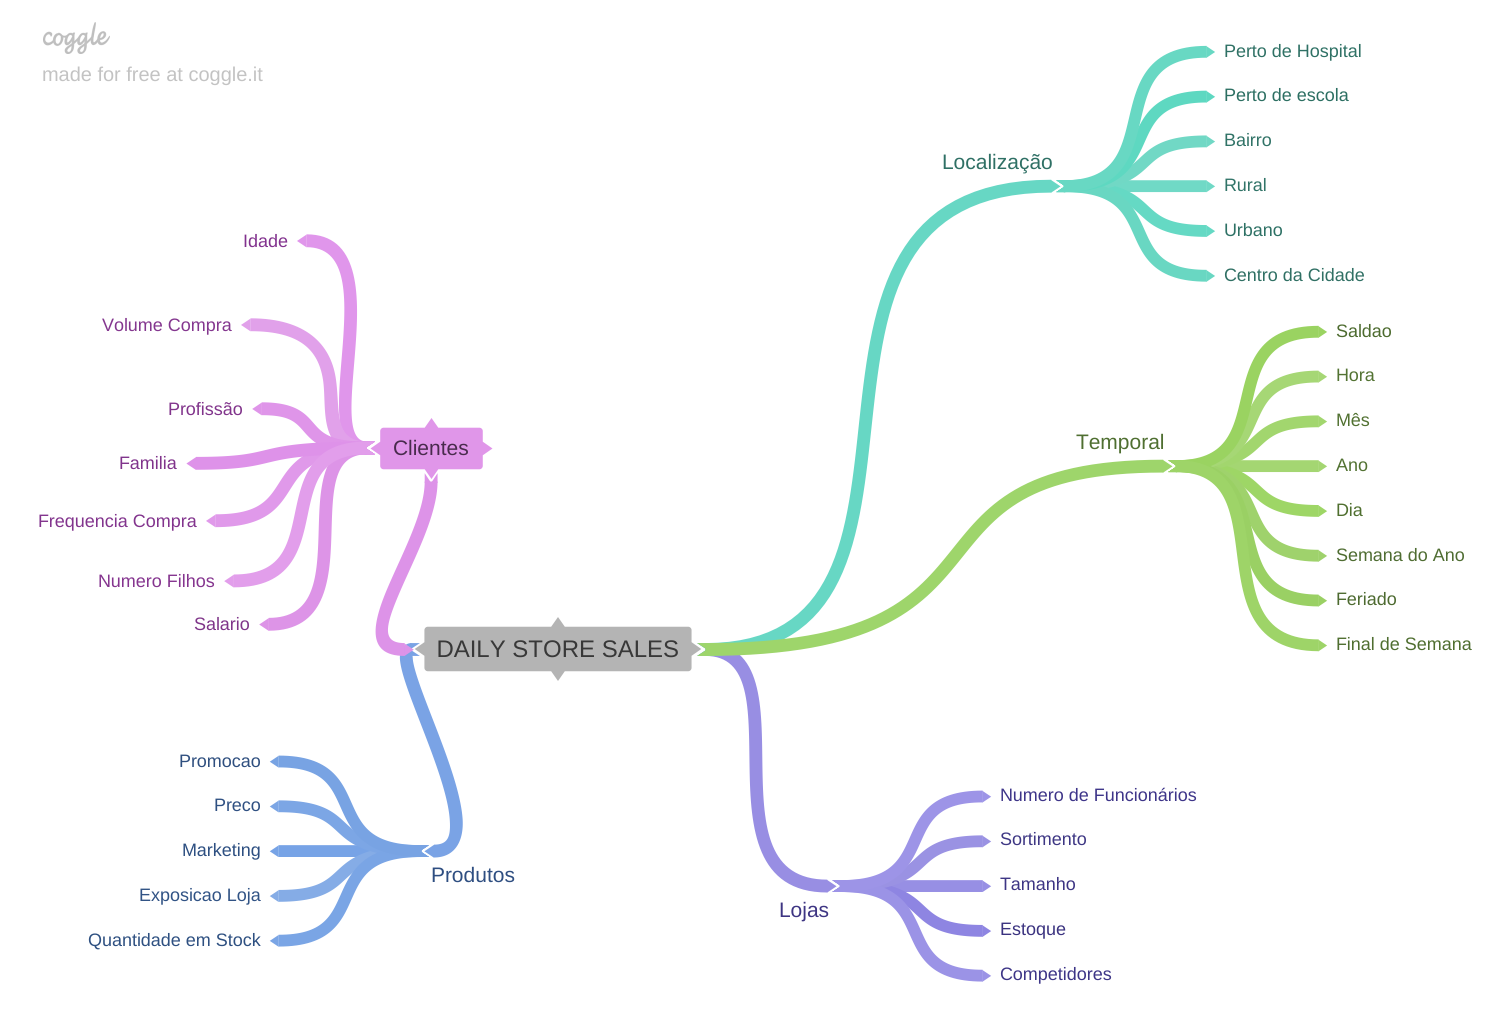

In [20]:
Image('../img/mindmapHypothesis.png')

## 2.1 Criacao das Hiposteses

### 2.1.1 Hipoteses da Loja 
**1.** Lojas com maior quadro de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo vendem mais 

### 2.1.2 Hipoteses Produto 

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expoem mais o produtos nas vitrines deveriam vender mais

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Loajs com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.**  Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais




### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6** Lojas deveriam vender menos durante os feriados escolares.



## 2.2 Lista Final de Hipótese 

**1** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo vendem mais 


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.**  Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [21]:
## criando novas colunas partir da coluna date

# year

df2['year'] = df2['date'].dt.year
# month 
df2['month'] = df2['date'].dt.month

# day 
df2['day'] = df2['date'].dt.day


# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week 
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'] , month= x['competition_open_since_month'] , day = 1), axis =1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since 
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta( days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

df2['promo_time_week'] = df2['promo_time_week'].astype(int)


# assortment 
#assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state holiday 
##  a = public holiday, b = Easter holiday, c = Christmas, 0 = None


df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


C:\Users\mathe\AppData\Local\Temp\ipykernel_1872\1153745933.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


## 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS 

In [22]:
df3 = df2.copy()



### 3.1 Filtragem das Linhas 


In [23]:
#### vou filtrar as linhas ,não faz sentido realizar previsao de vendas quando a loja tiver fechada 
#### e nem quando não houver vendas

df3 = df3.loc[(df3['open'] !=0 ) & (df3['sales'] > 0 ), :]

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### 3.2 Filtragem das Colunas 

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

## 4.0 PASSO 04 - ANALISE EXPLORATORIA DOS DADOS 


In [25]:
df4 = df3.copy()

### 4.1 Analise Univariada 

#### 4.1.1. Response Variable

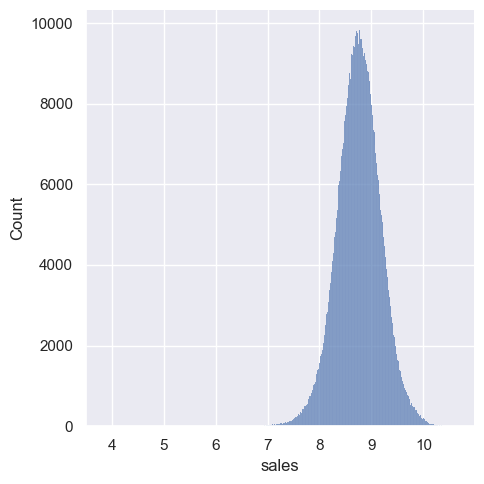

In [26]:
sns.displot(np.log1p(df4['sales']));

### 4.1.2 Numerical Variable 

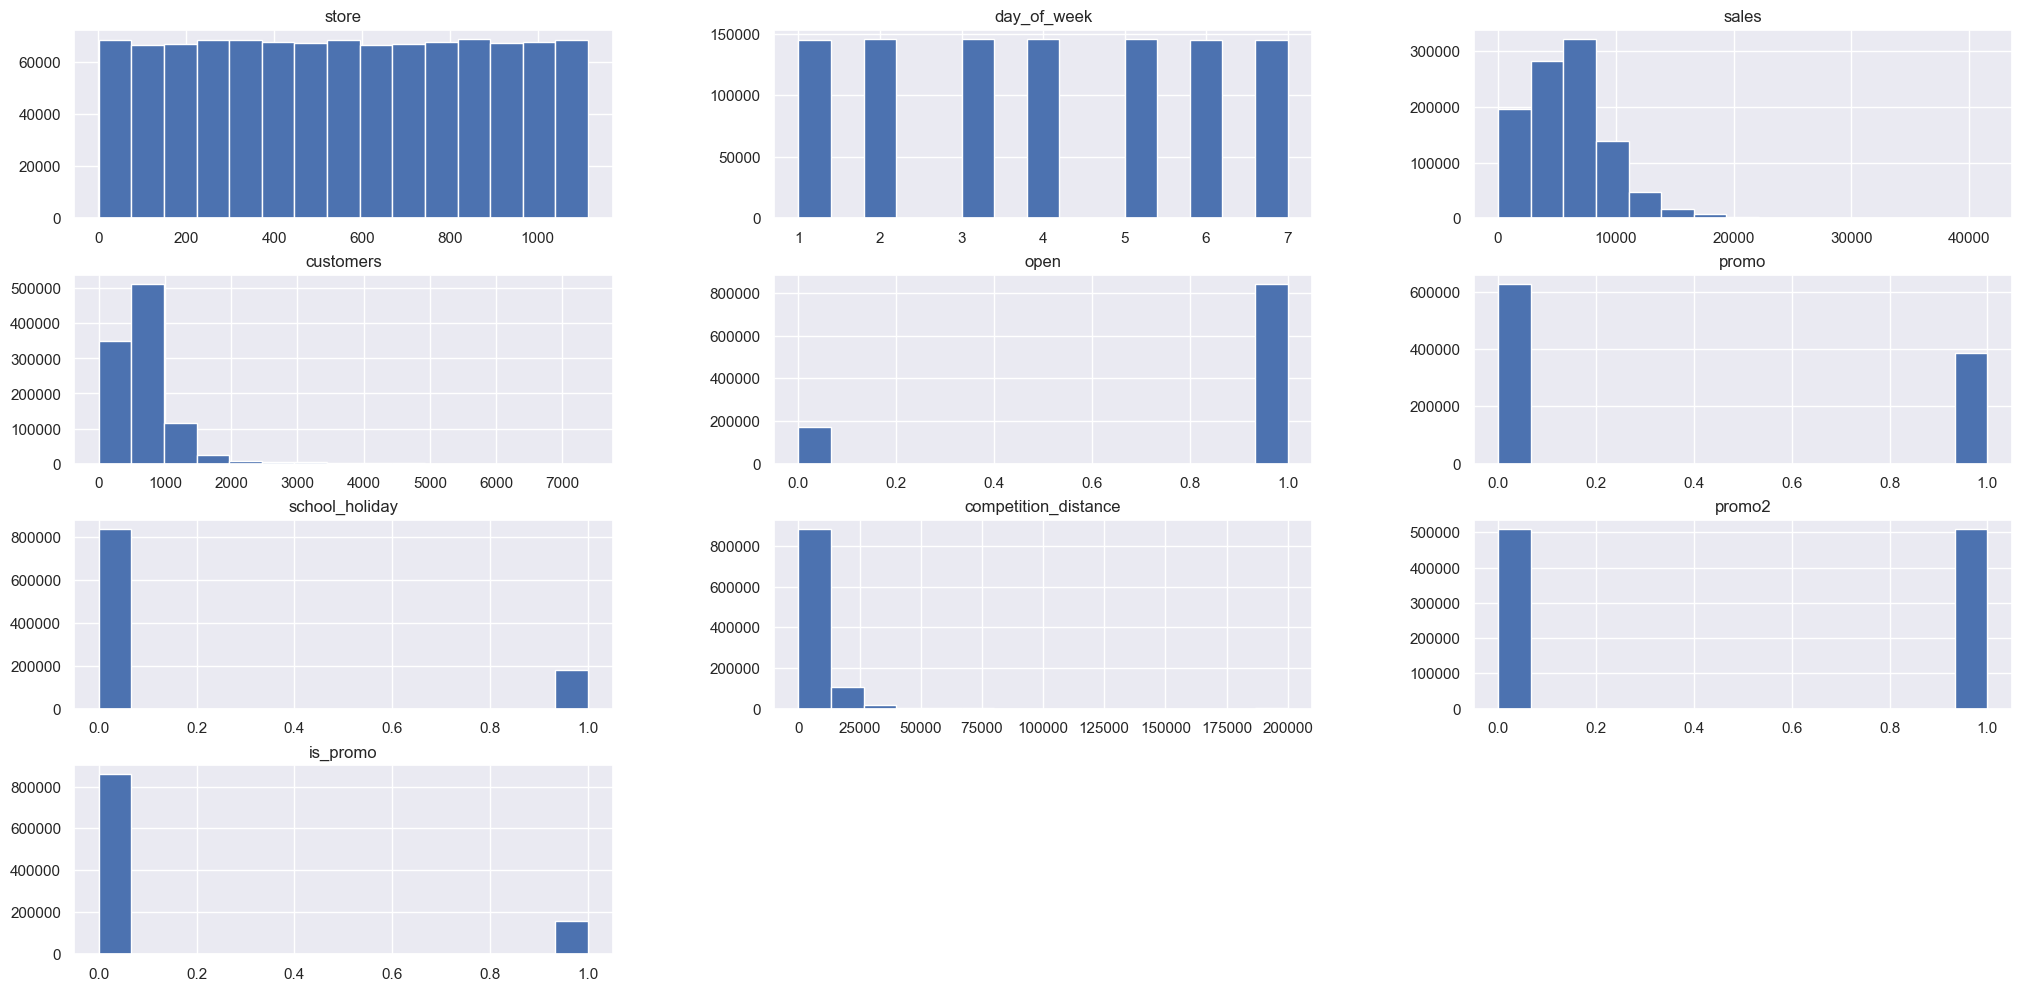

In [27]:
num_attributes.hist(bins=15);

### 4.1.3 Categorical Variable 

In [28]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    Easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [29]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [30]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

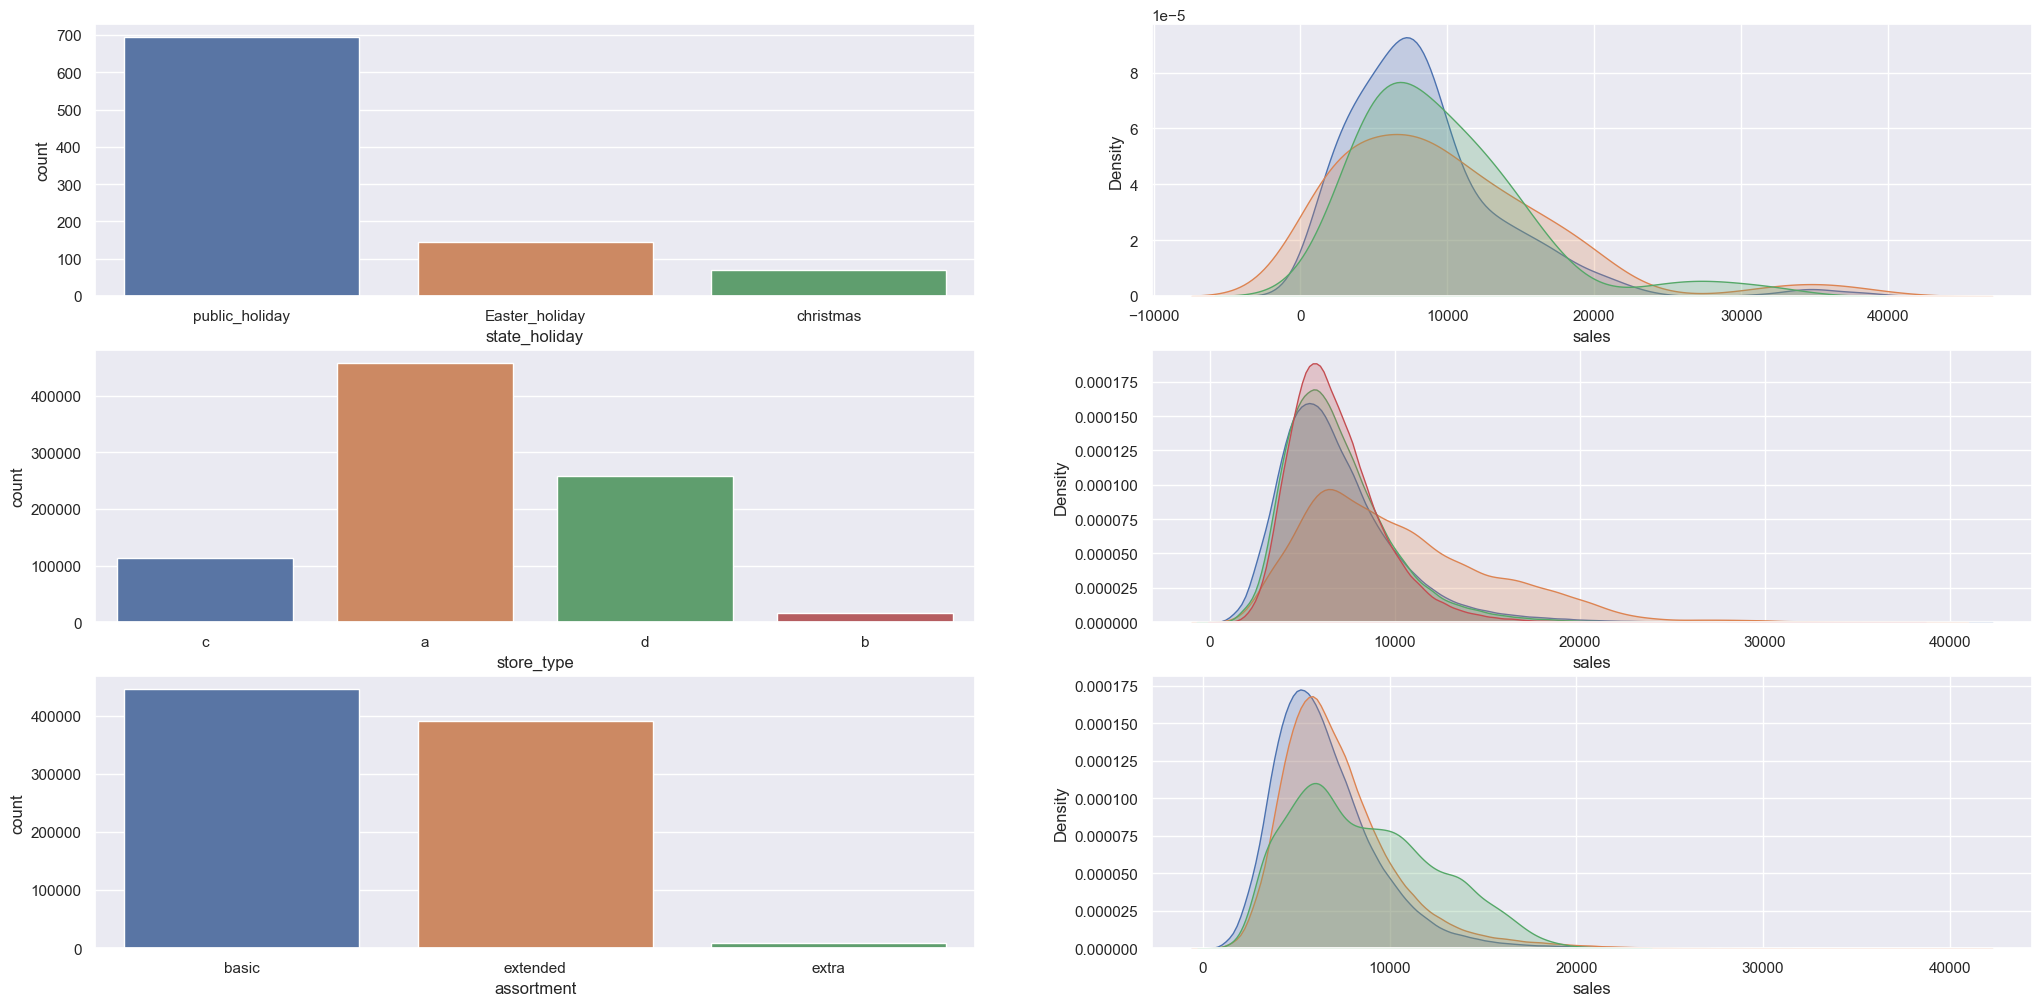

In [31]:
# state_holiday 
plt.subplot(3,2,1)
a = df4.loc[(df4['state_holiday'] != 'regular_day'), :]
sns.countplot(x = a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4.loc[(df4['state_holiday'] == 'public_holiday'), 'sales'], label = 'public_holiday', fill = True);
sns.kdeplot(df4.loc[(df4['state_holiday'] == 'Easter_holiday'), 'sales'], label = 'easter_public', fill = True);
sns.kdeplot(df4.loc[(df4['state_holiday'] == 'christmas'), 'sales'], label = 'christmas', fill = True);

## store_type
plt.subplot(3,2,3)
sns.countplot(x = df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4.loc[(df4['store_type'] == 'a'), 'sales'], label = 'a', fill = True);
sns.kdeplot(df4.loc[(df4['store_type'] == 'b'), 'sales'], label = 'b', fill = True);
sns.kdeplot(df4.loc[(df4['store_type'] == 'c'), 'sales'], label = 'c', fill = True);
sns.kdeplot(df4.loc[(df4['store_type'] == 'd'), 'sales'], label = 'd', fill = True);


## assortment
plt.subplot(3,2,5)
sns.countplot(x = df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4.loc[(df4['assortment'] == 'basic'), 'sales'], label = 'basic', fill = True);
sns.kdeplot(df4.loc[(df4['assortment'] == 'extended'), 'sales'], label = 'extended', fill = True);
sns.kdeplot(df4.loc[(df4['assortment'] == 'extra'), 'sales'], label = 'extra', fill = True);


### 4.2 Analise Bivariada 

### H1. Lojas com maior sortimentos deveriam vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS  

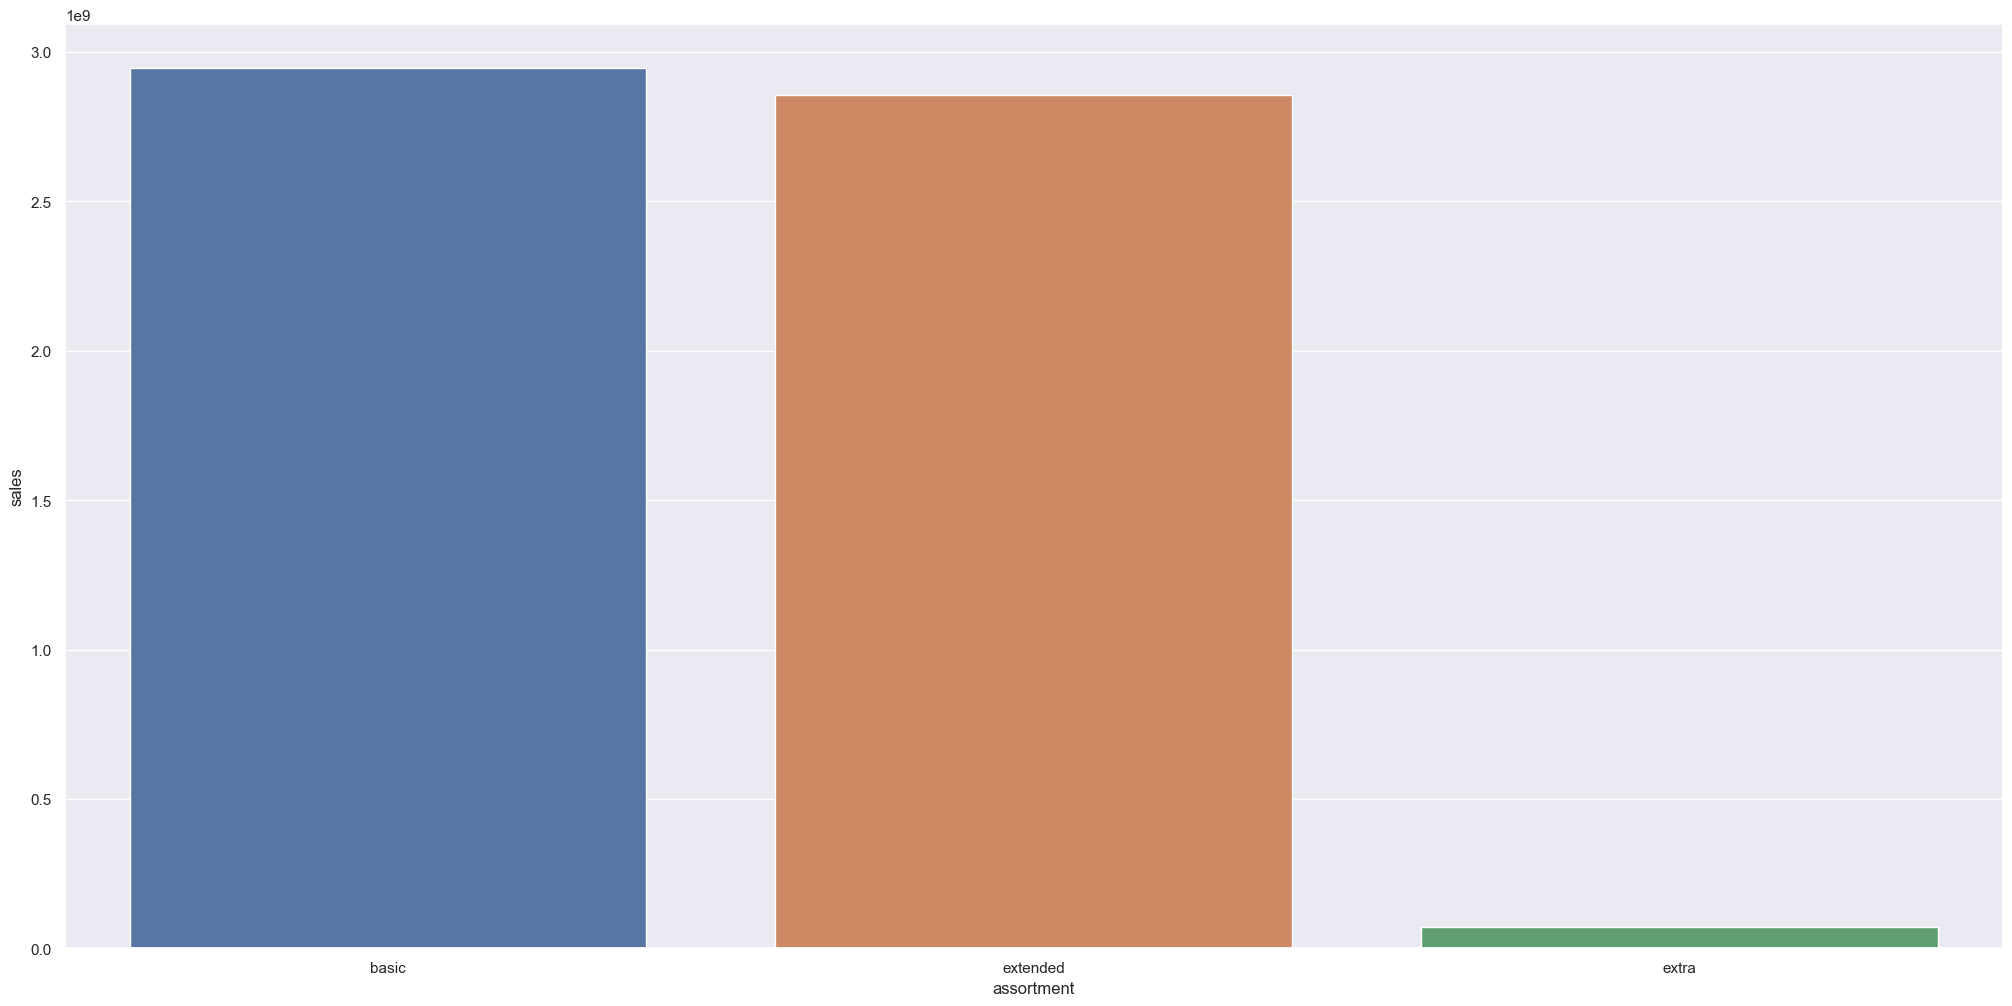

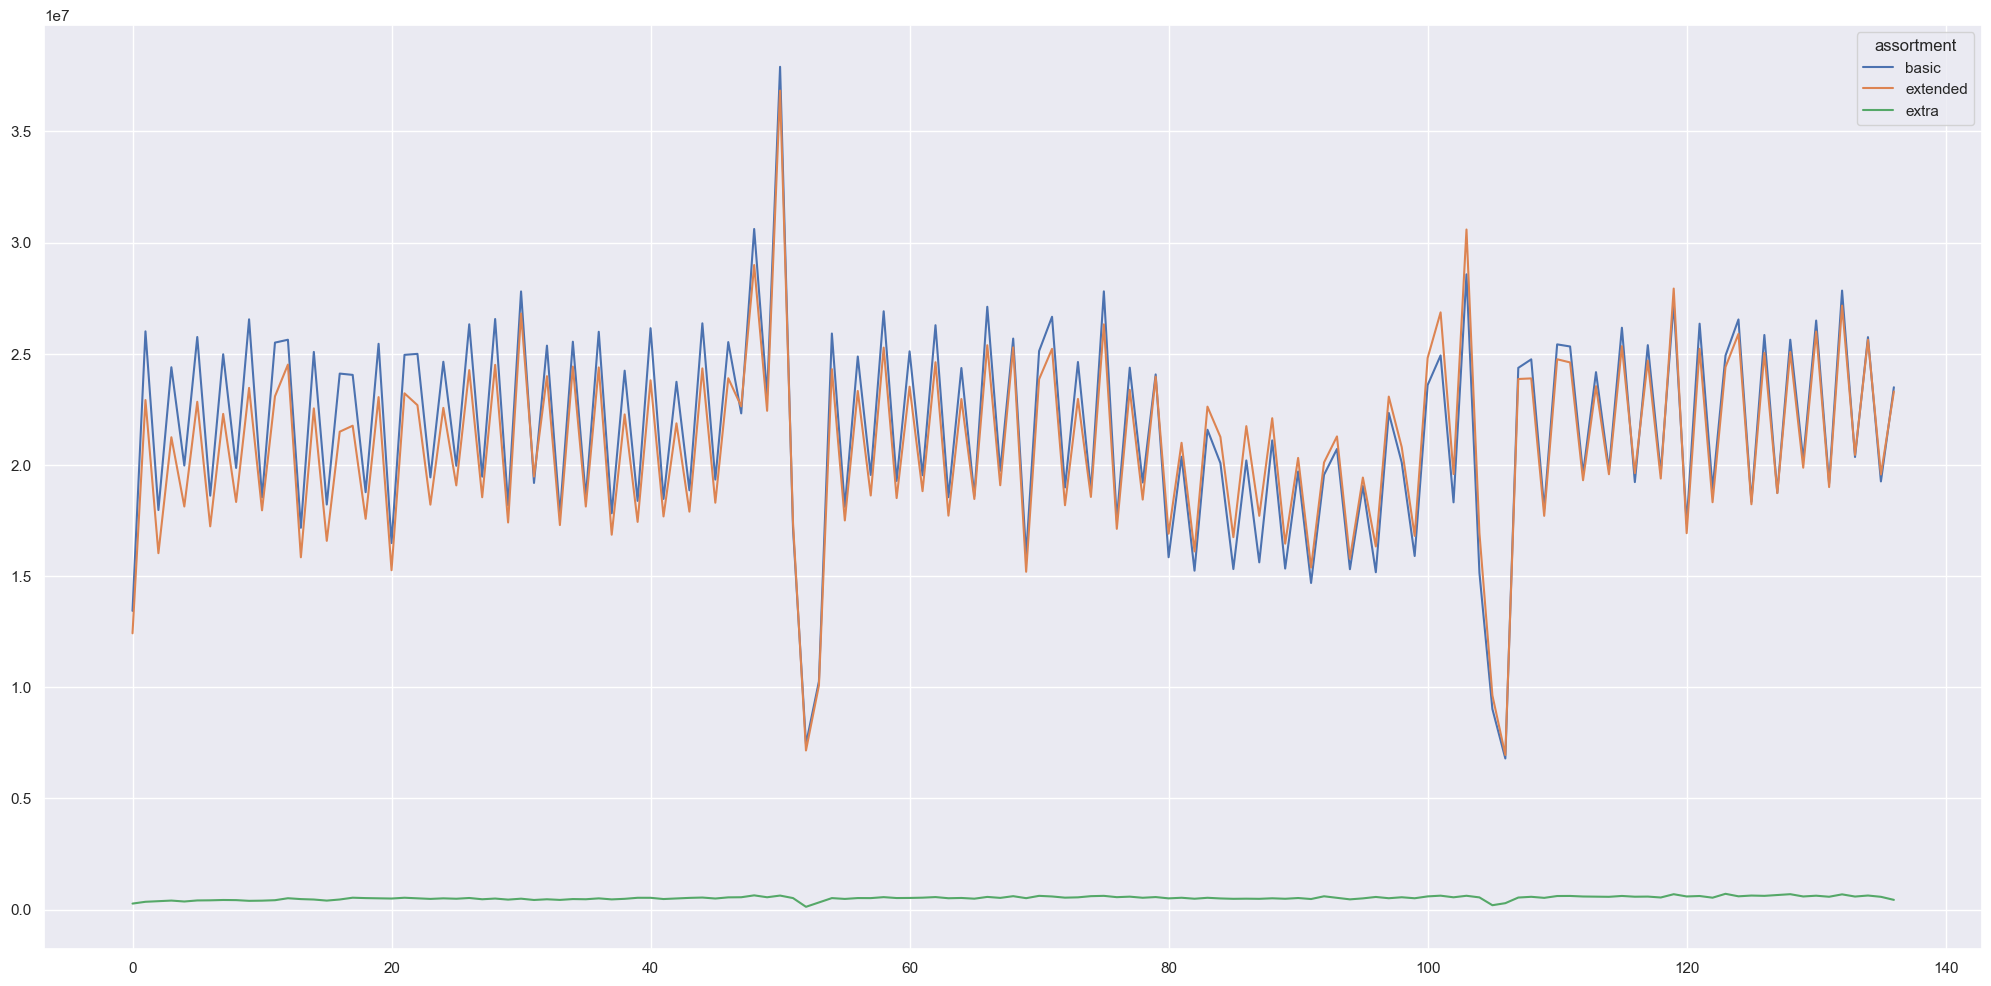

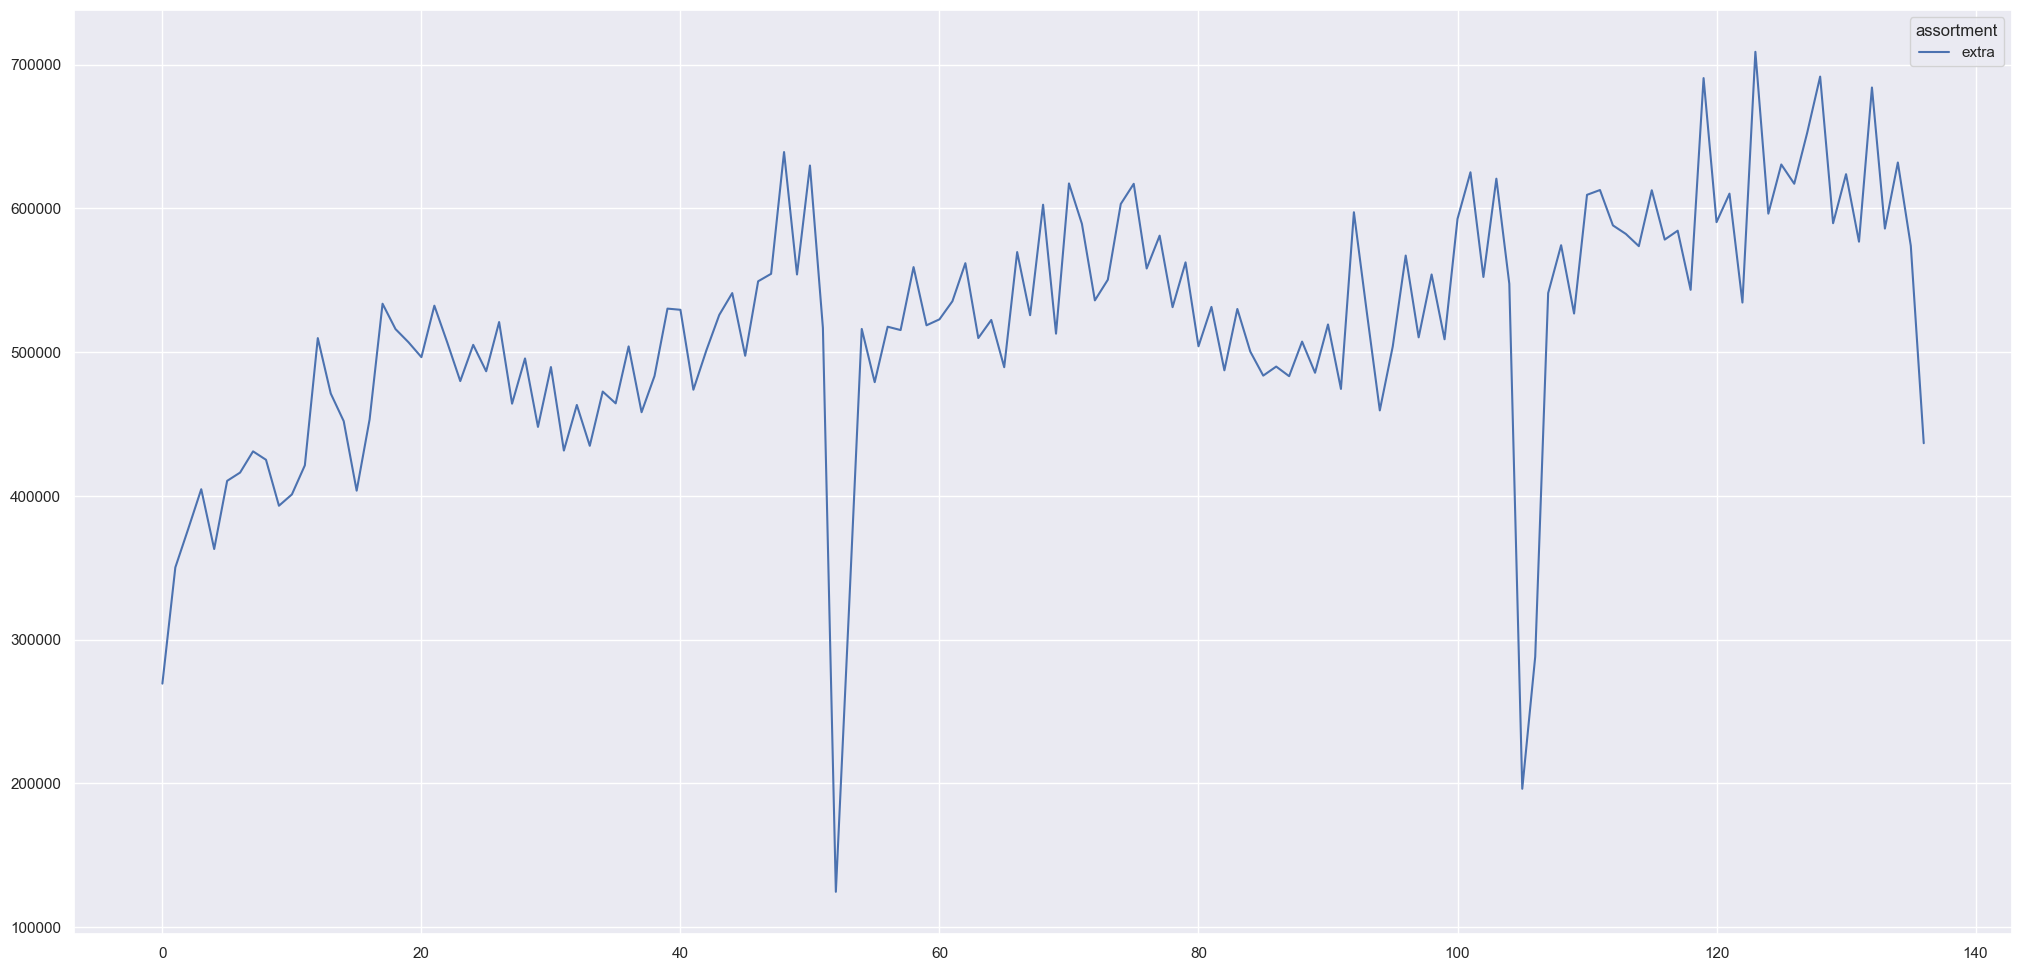

In [32]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

sns.barplot(x = 'assortment', y= 'sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()


aux3 = aux2.pivot(index = 'year_week' , columns = 'assortment', values = 'sales').reset_index().plot()


aux4 = aux2.loc[(aux2['assortment'] == 'extra'), :]
aux5 = aux4.pivot(index= 'year_week', columns= 'assortment' , values = 'sales').reset_index().plot()


### **H2** Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas que tem competidores mais próximos vendem MAIS e NÃO MENOS 

C:\Users\mathe\AppData\Local\Temp\ipykernel_1872\1169306335.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method= 'pearson'), annot = True);


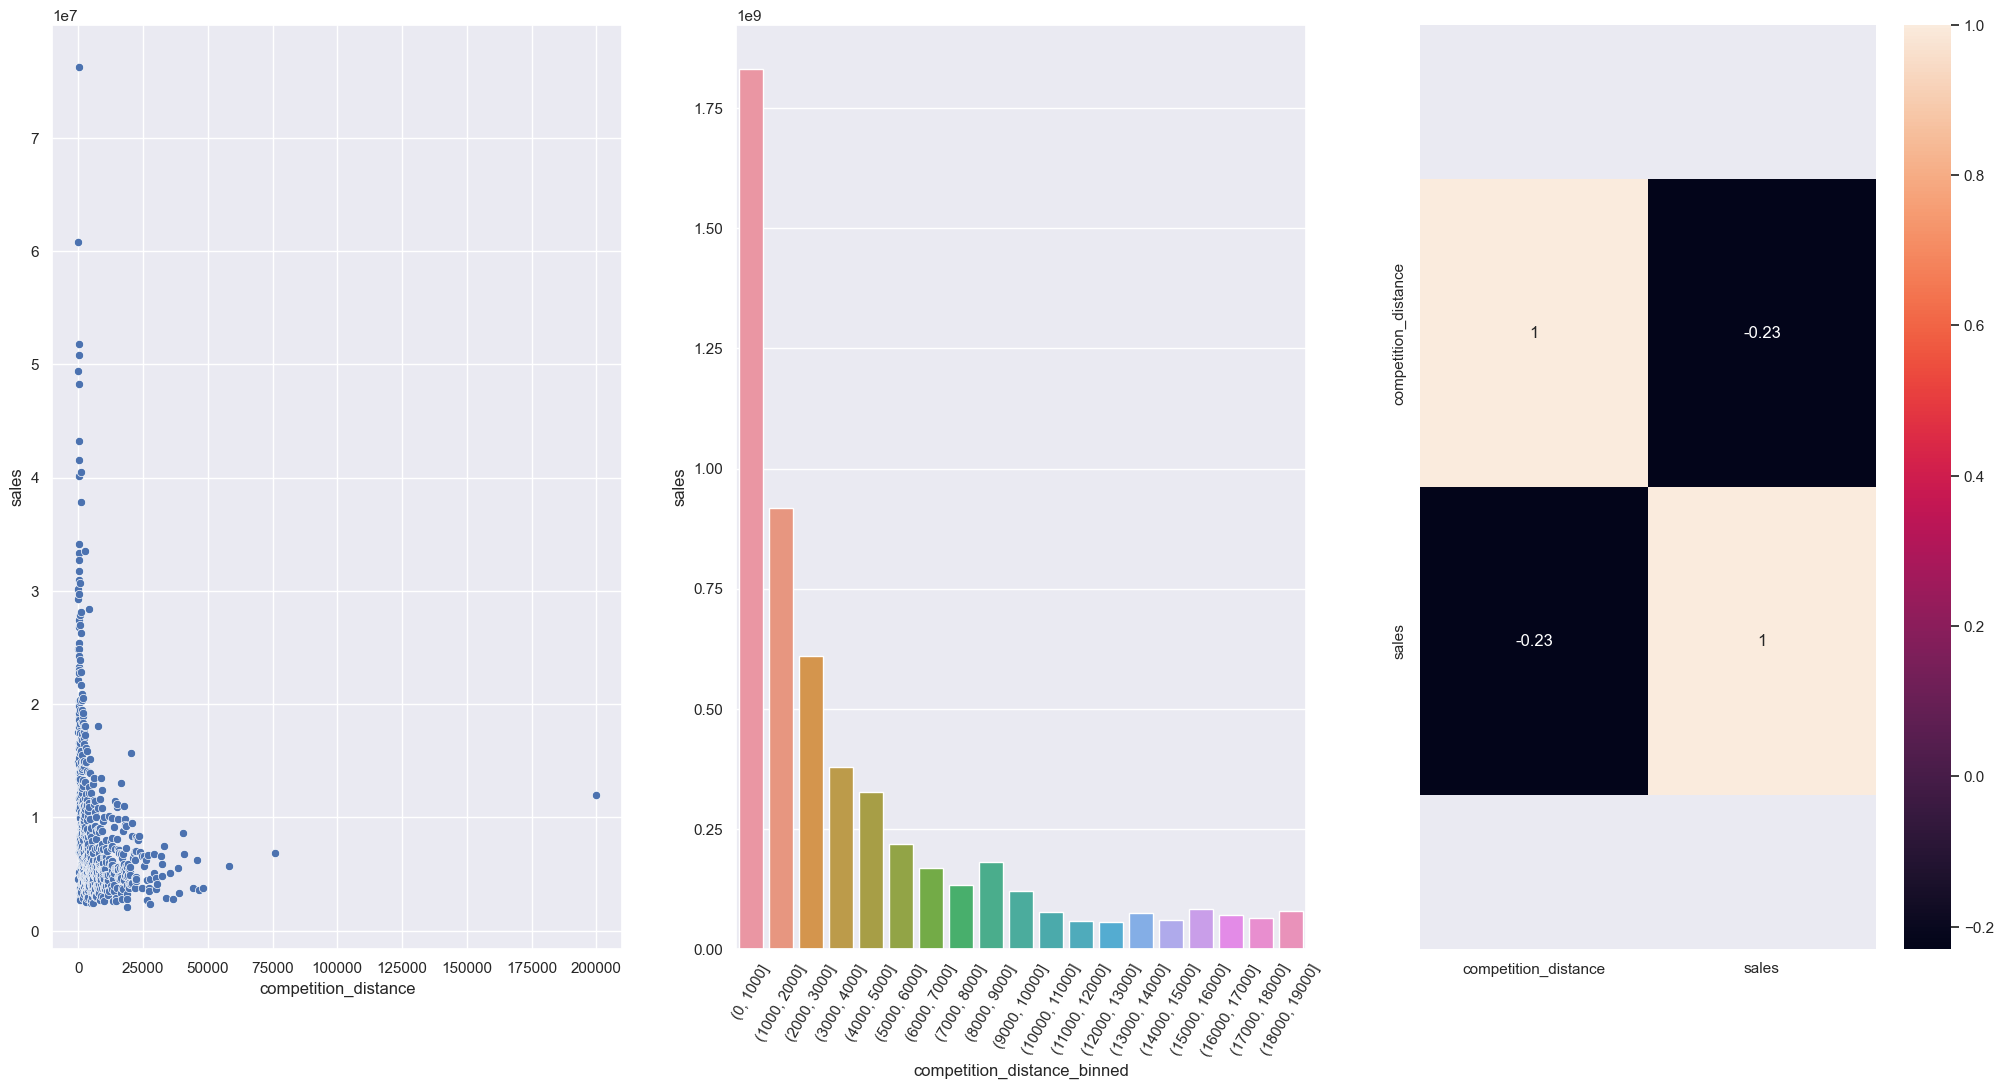

In [33]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales' , data = aux1)

plt.subplot(1,3, 2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2 );
plt.xticks(rotation = 60)

plt.subplot(1,3, 3)
x = sns.heatmap(aux1.corr(method= 'pearson'), annot = True);

bottom, top = x.get_ylim()

x.set_ylim (bottom + 0.5 , top-0.5);


### **H3.** Lojas com competidores à mais tempo vendem mais 
**FALSO** Lojas com COMPETIDORES à mais tempo vendem MENOS


C:\Users\mathe\AppData\Local\Temp\ipykernel_1872\736197287.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method= 'pearson'), annot = True);


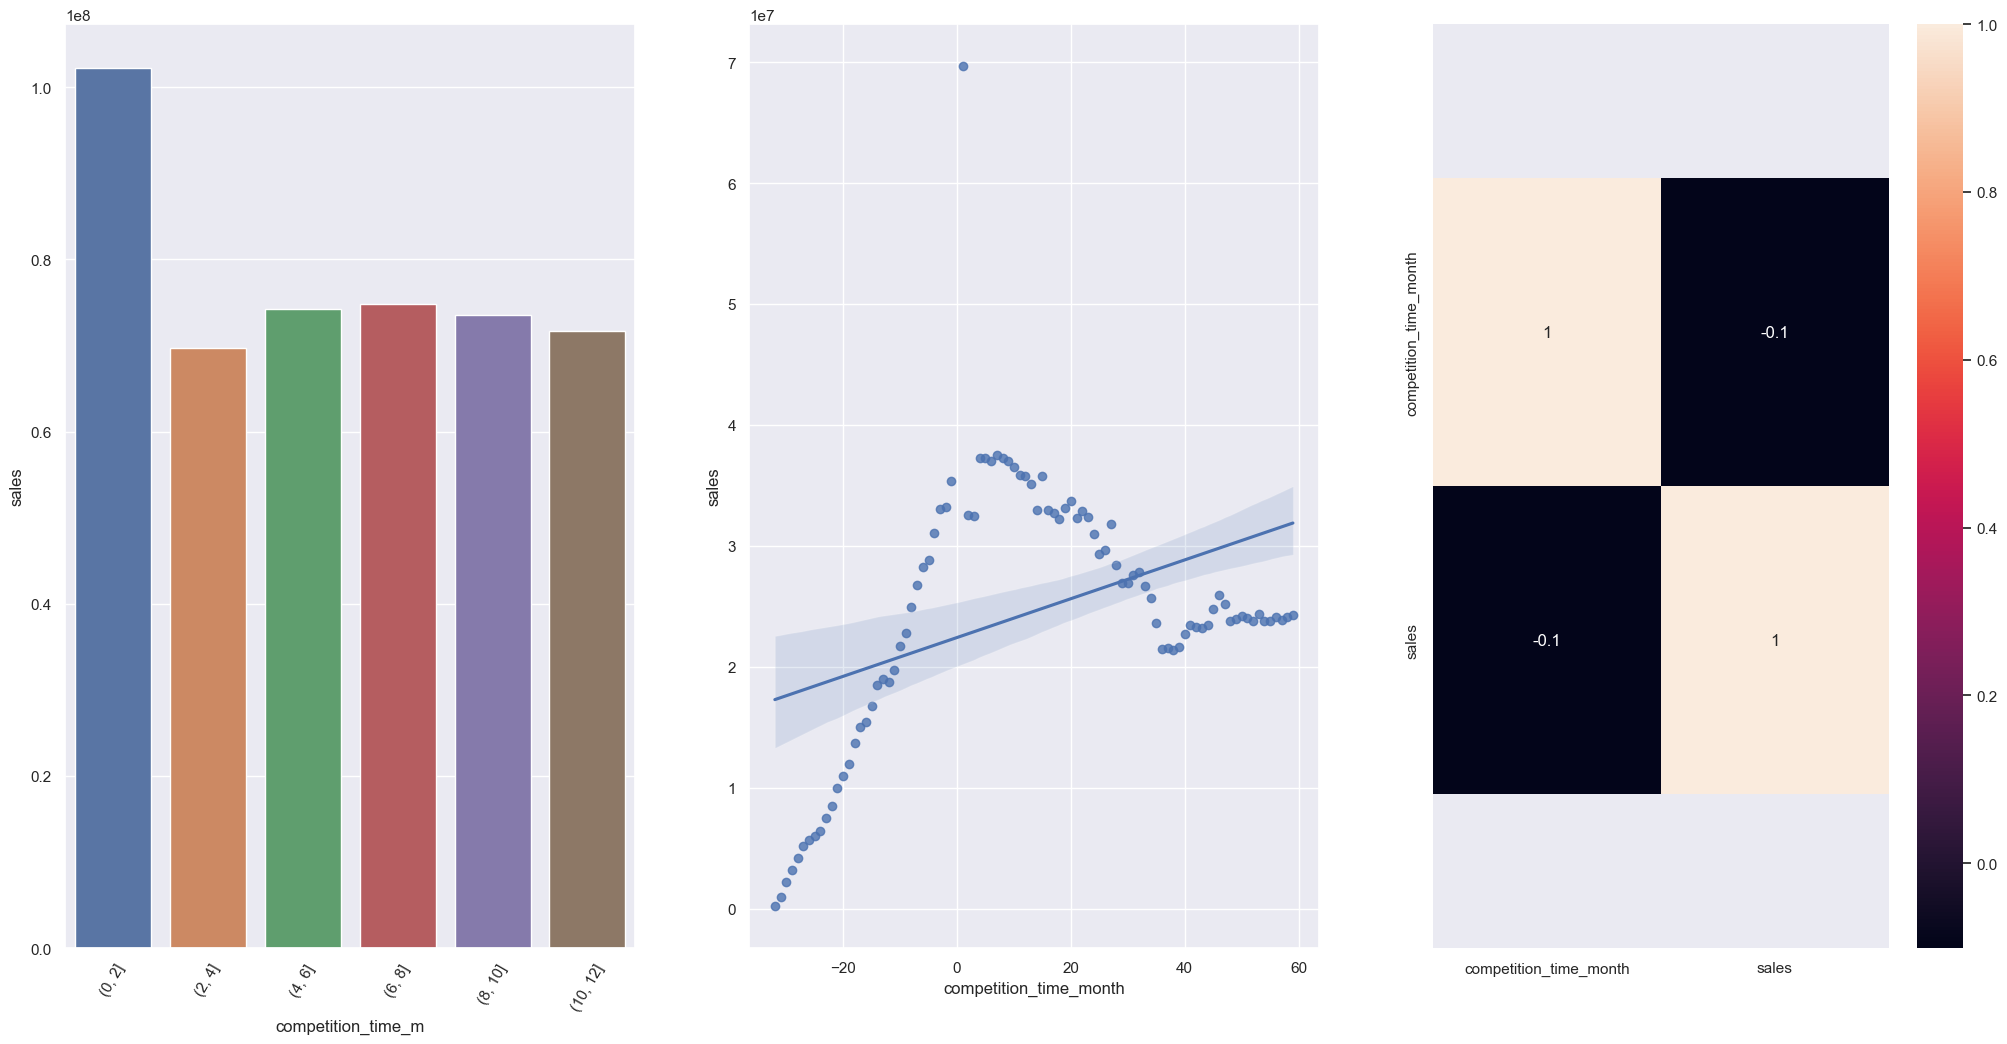

In [34]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1.loc[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0), :]

bins = list(np.arange(0,14, 2))
aux1['competition_time_m'] = pd.cut(aux1['competition_time_month'], bins = bins)
aux3 = aux1[['competition_time_m','sales']].groupby('competition_time_m').sum().reset_index()


sns.barplot(x = 'competition_time_m' , y = 'sales' , data = aux3);
plt.xticks(rotation = 60)

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month' , y = 'sales' , data = aux2);


plt.subplot(1,3, 3)
x = sns.heatmap(aux1.corr(method= 'pearson'), annot = True);


bottom, top = x.get_ylim()
x.set_ylim (bottom + 0.5 , top-0.5);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas que tem promoções ativas por mais tempo vendem MENOS , as vendas diminui ao passar da dos dias da promoção

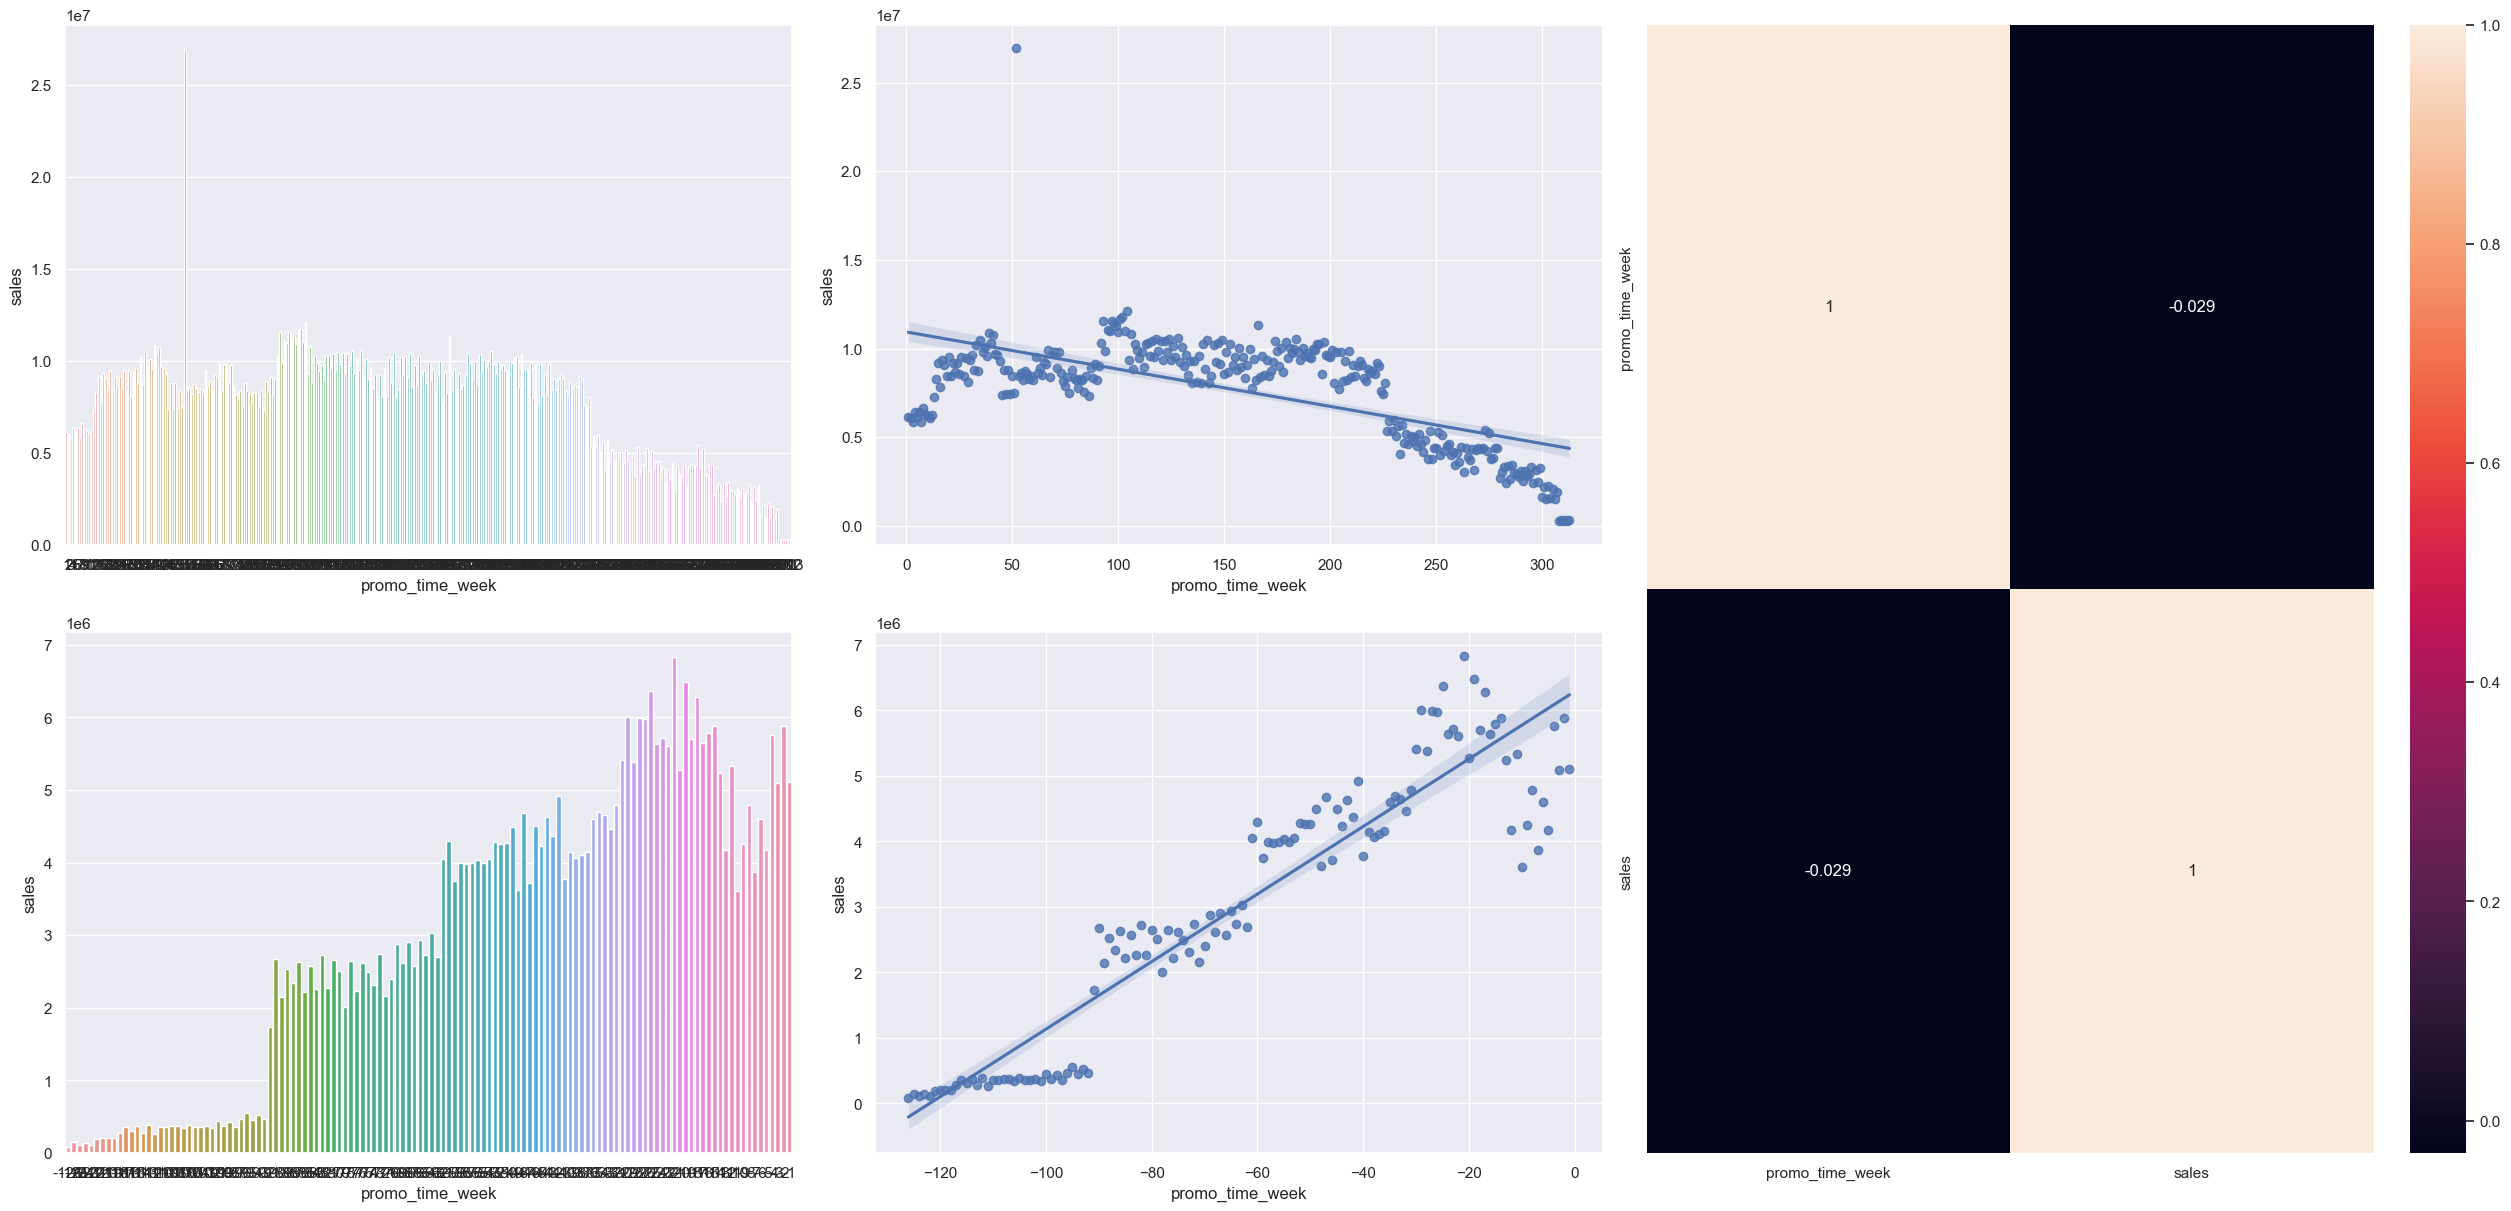

In [35]:
## todos os promo_time_week com valores negativos significa que o produto foi vendido na promo extendida
## todos os promo_time_week com valores positivos significa que os produtos foram vendidos no dia da promo


fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])
f2_ax5 = fig2.add_subplot(spec2[:, 2])


aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0 ] ## promo extendida
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2, ax= f2_ax1);
plt.xticks(rotation = 60);


sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2, ax = f2_ax2);

aux3 = aux1[aux1['promo_time_week'] < 0 ] ## promo regular
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3, ax = f2_ax3);
plt.xticks(rotation = 90)

sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3, ax = f2_ax4);

sns.heatmap(aux1.corr( method = 'pearson'), annot = True, ax = f2_ax5);
plt.xticks(rotation = 0);


### **H5.**  Lojas com mais dias de promoção deveriam vender mais.


### **H6.** Lojas com mais promoções consecutivas deveriam vender mais

**FALSA** Lojas com maias promoções consecutivas vendem menos 

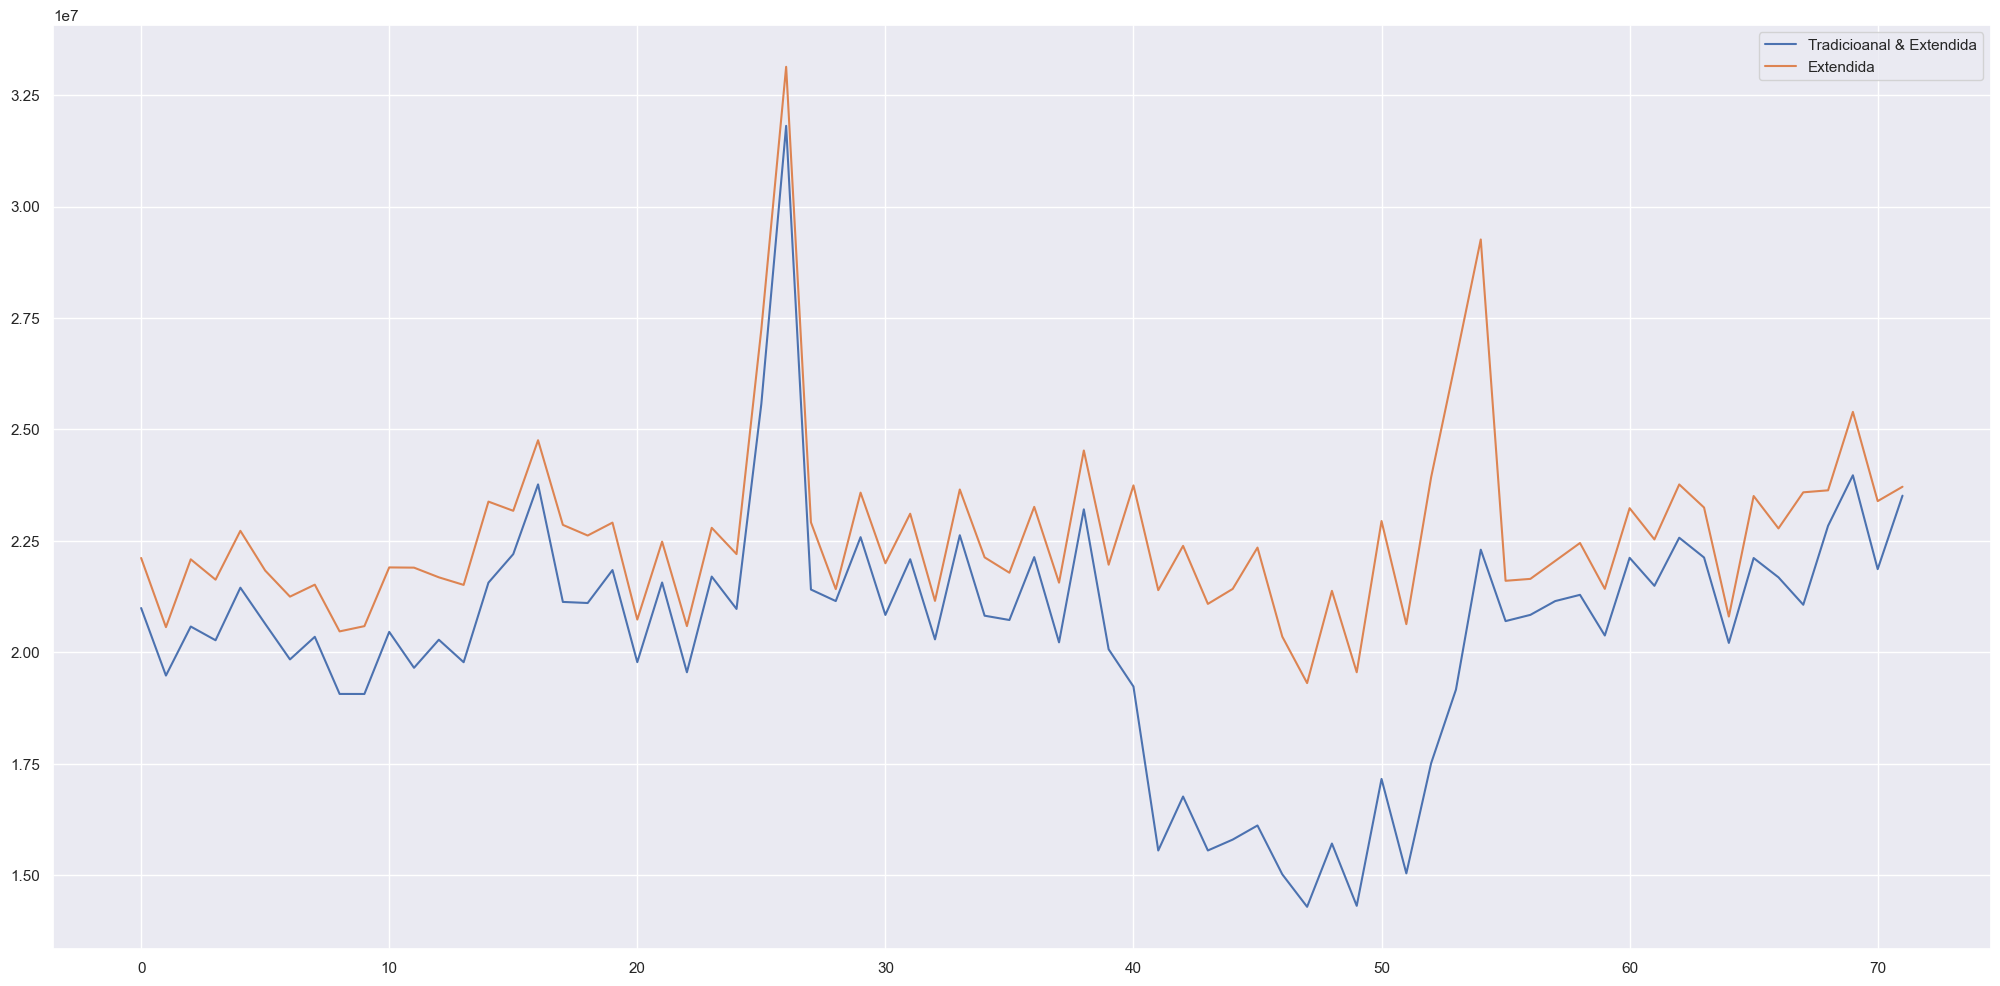

In [36]:
aux1 = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 1), ['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax1 = aux1.plot()

aux2 = df4.loc[(df4['promo'] == 1 ) & (df4['promo2'] == 0 ), ['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax1 );

plt.legend(labels = ['Tradicioanal & Extendida', 'Extendida'])





### **H7.** Lojas abertas durante o natal deveriam vender mais.
**FALSA** Lojas vendem menos no natal 

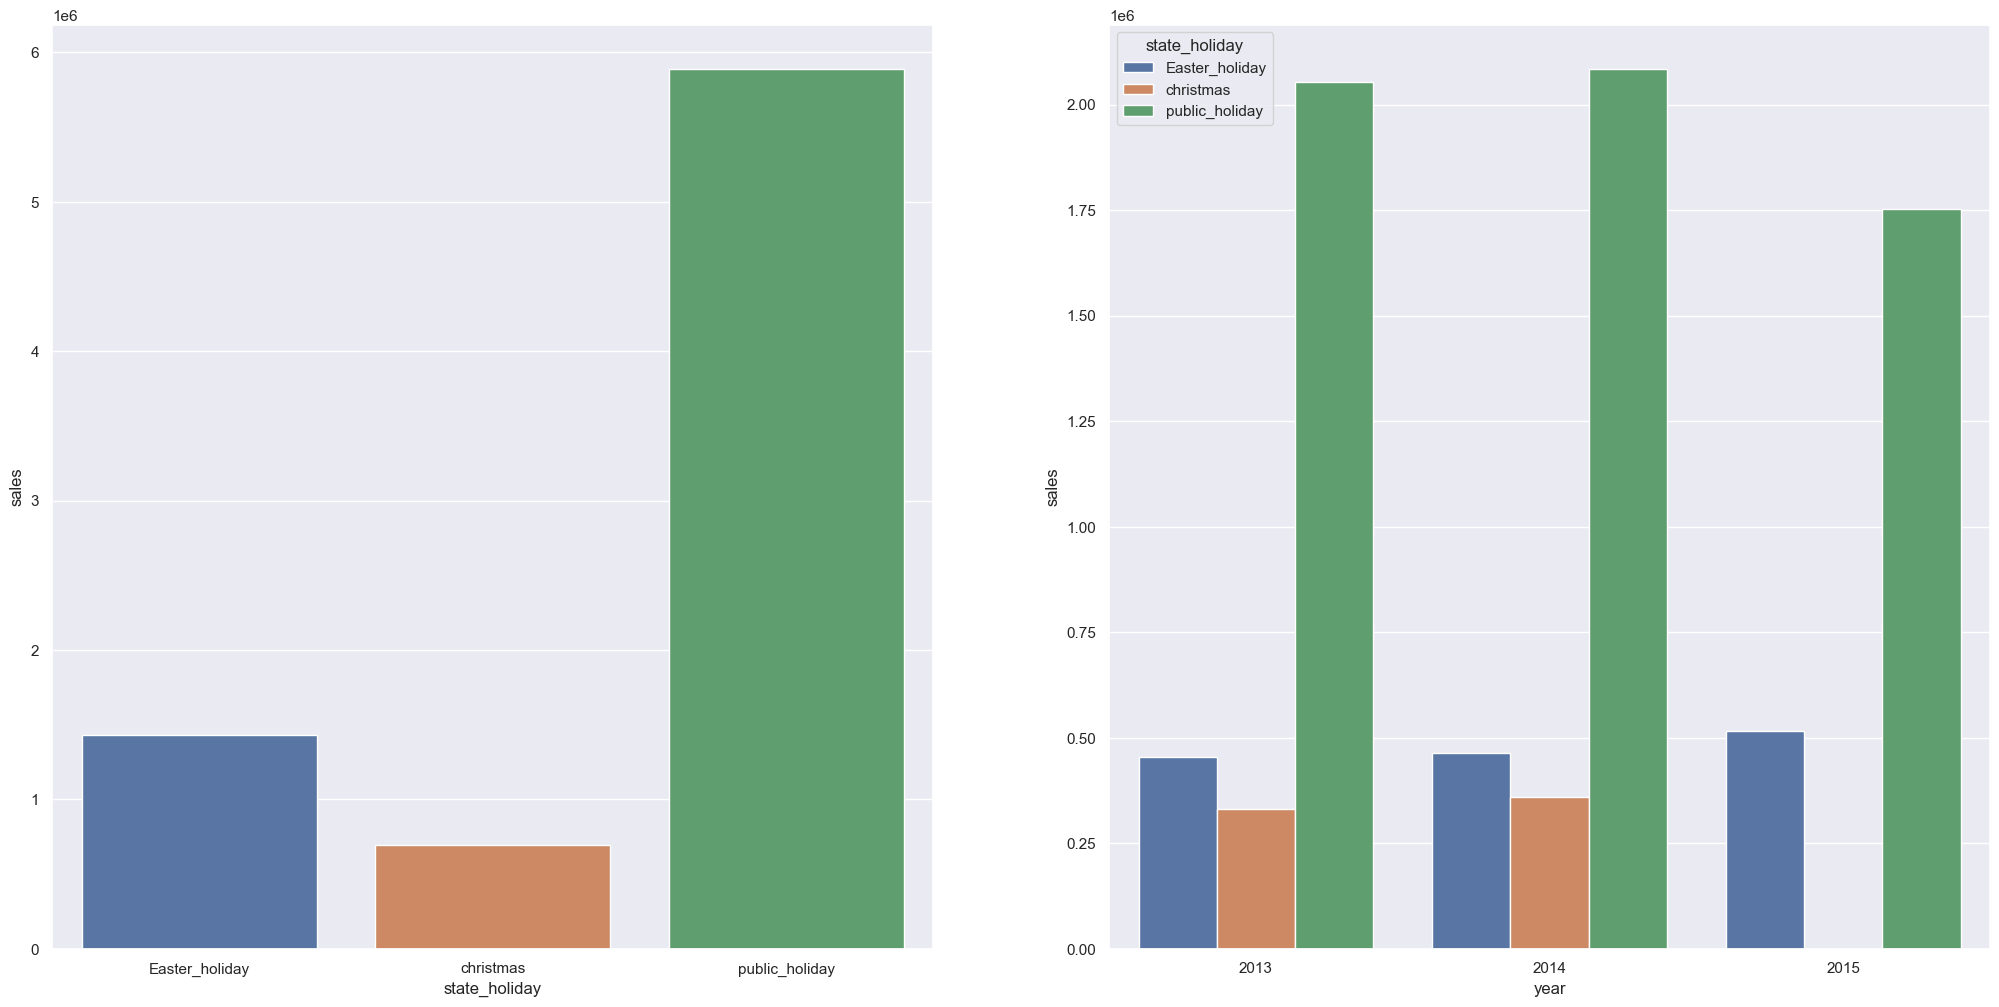

In [37]:
aux = df4.loc[(df4['state_holiday'] != 'regular_day'), :]
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday',  data = aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos 


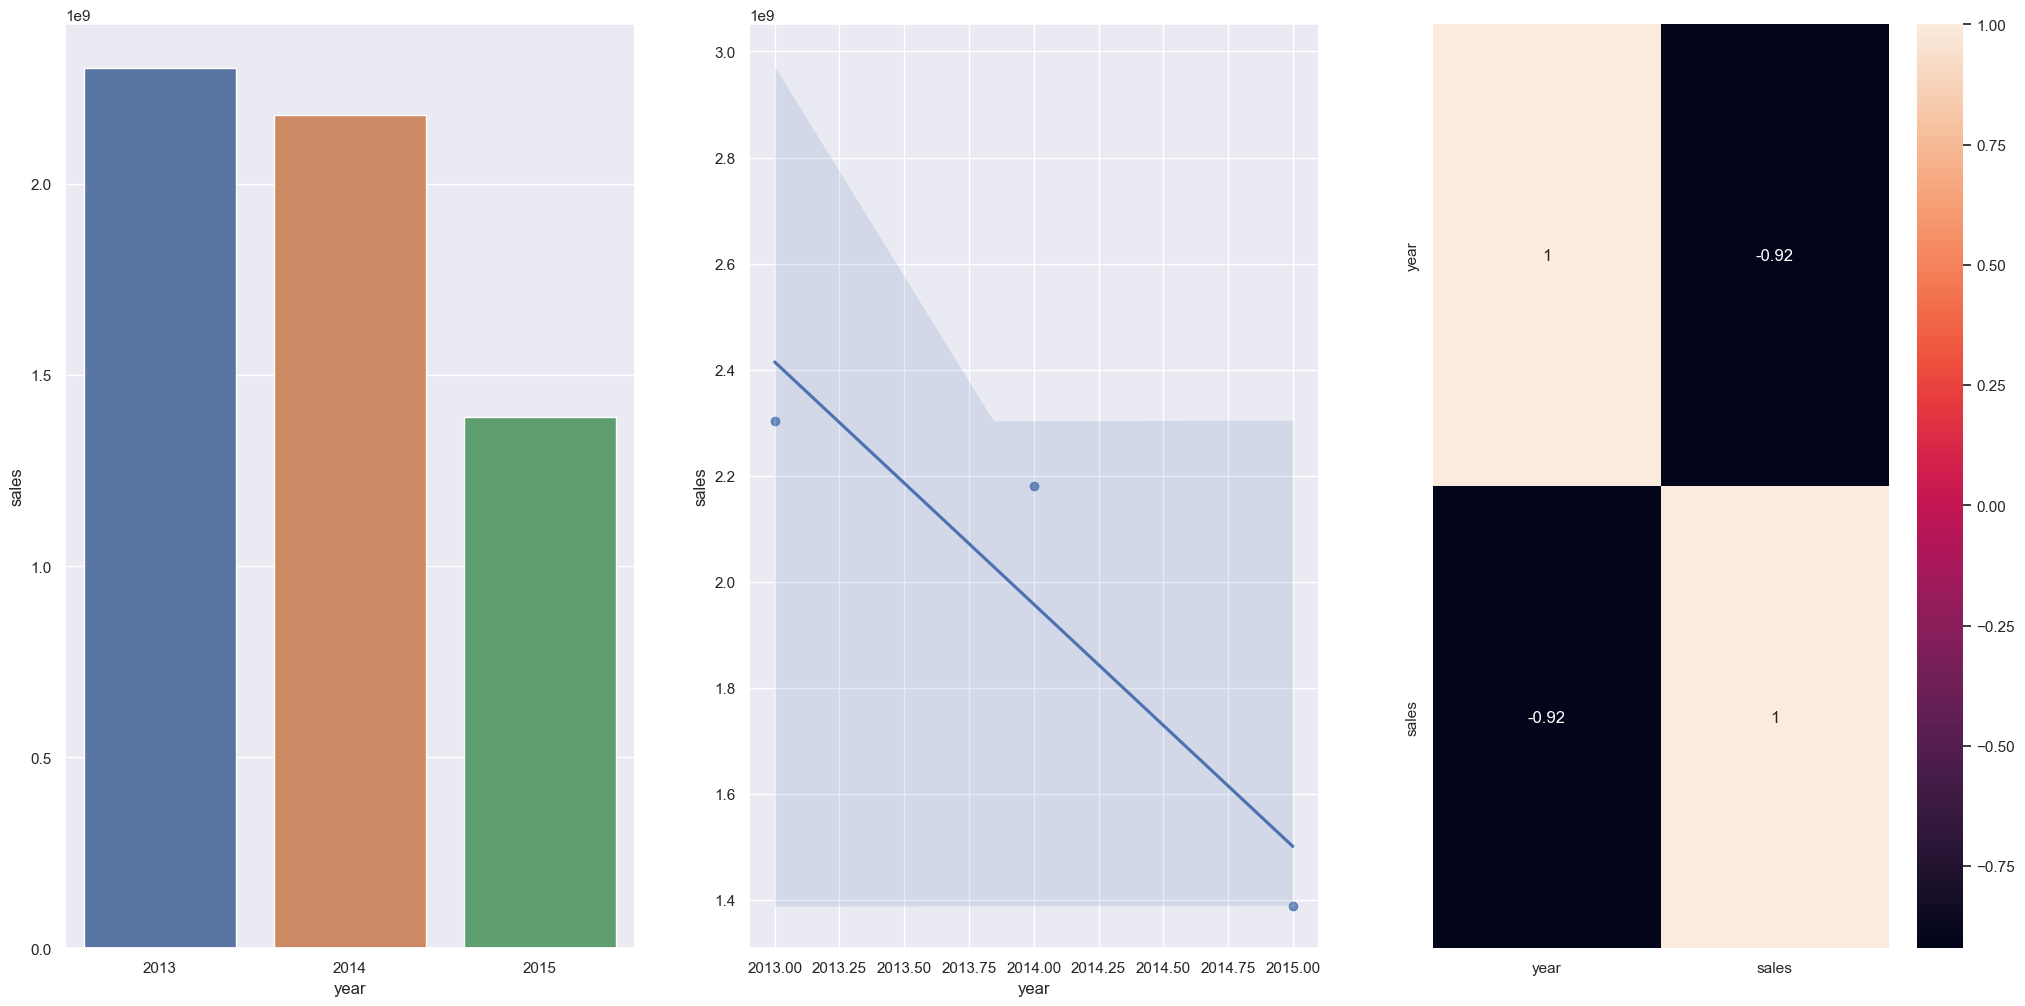

In [38]:
plt.subplot(1,3,1)
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data= aux);

plt.subplot(1,3,2)
sns.regplot( x = 'year', y= 'sales' , data = aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method = 'pearson'), annot= True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem menos no segundo semestre no ano 

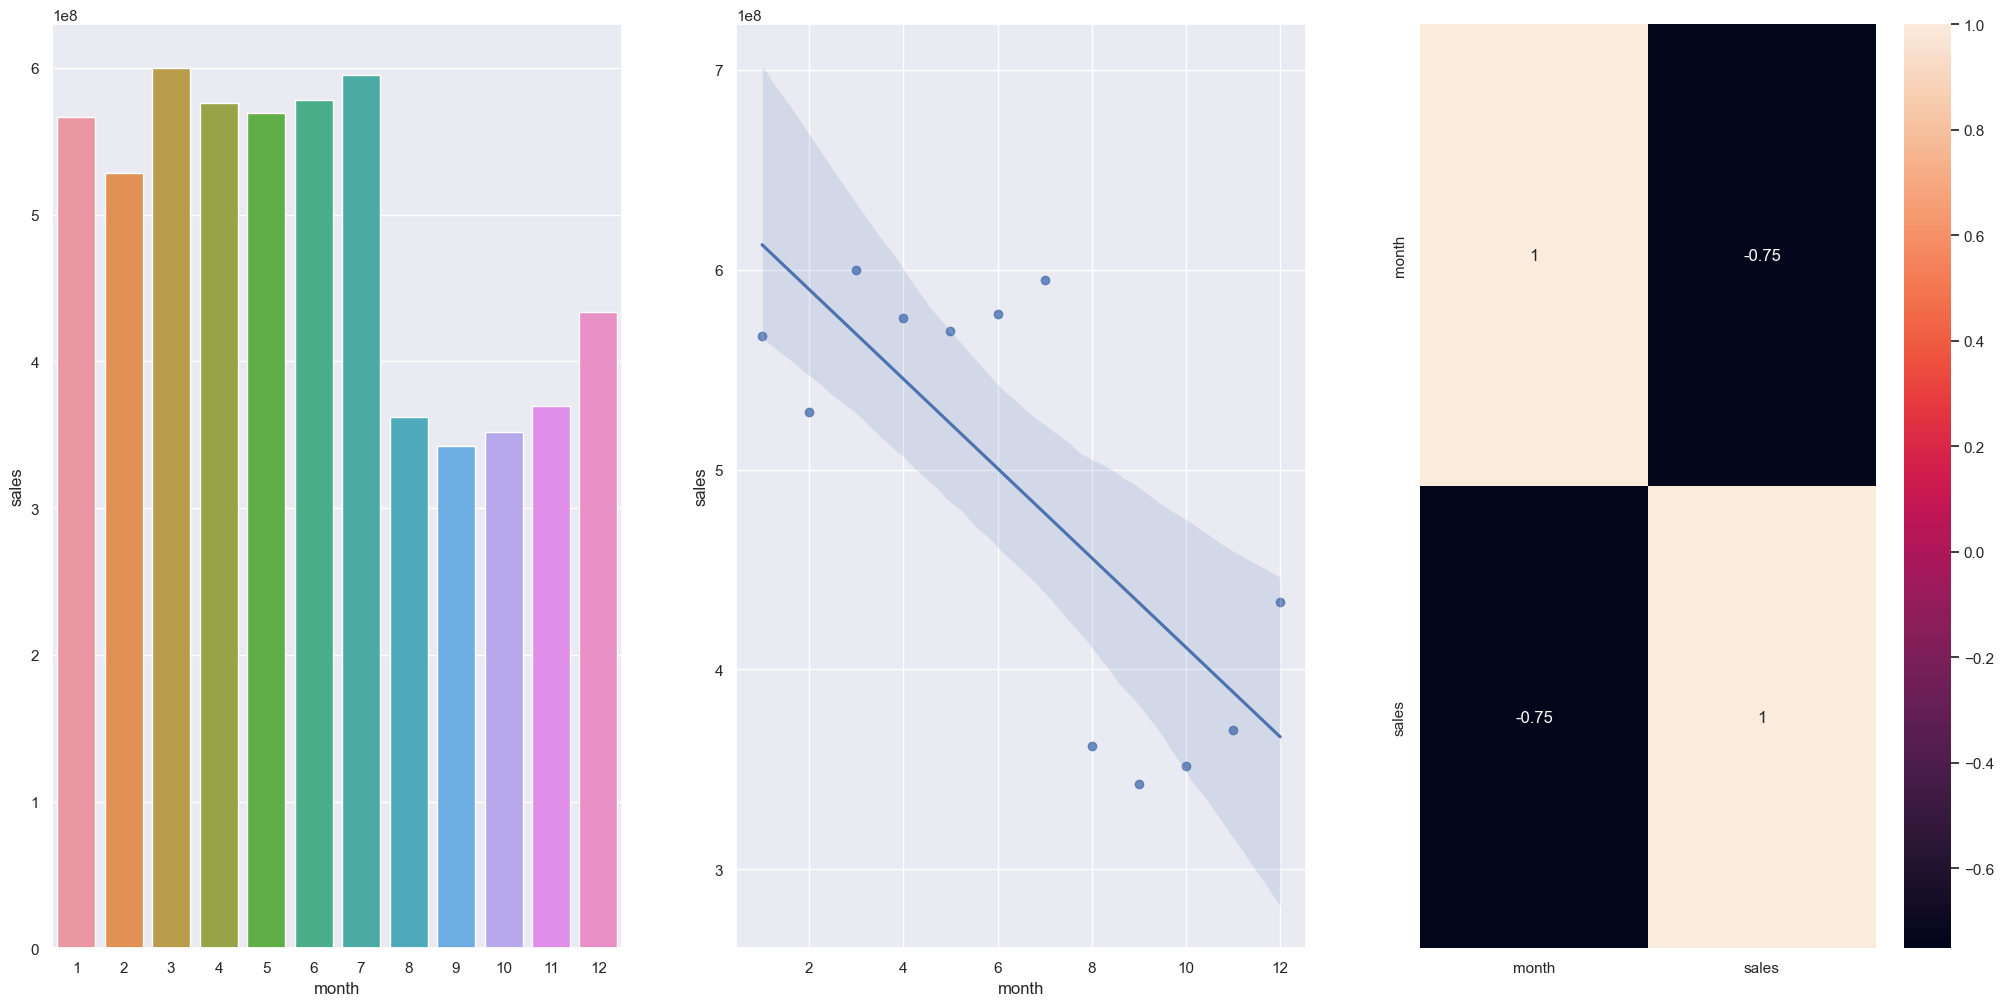

In [39]:
plt.subplot(1,3,1)



aux1 = df4[['sales', 'month']].groupby('month').sum().reset_index()


sns.barplot(x = 'month', y = 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'month', y= 'sales' , data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 

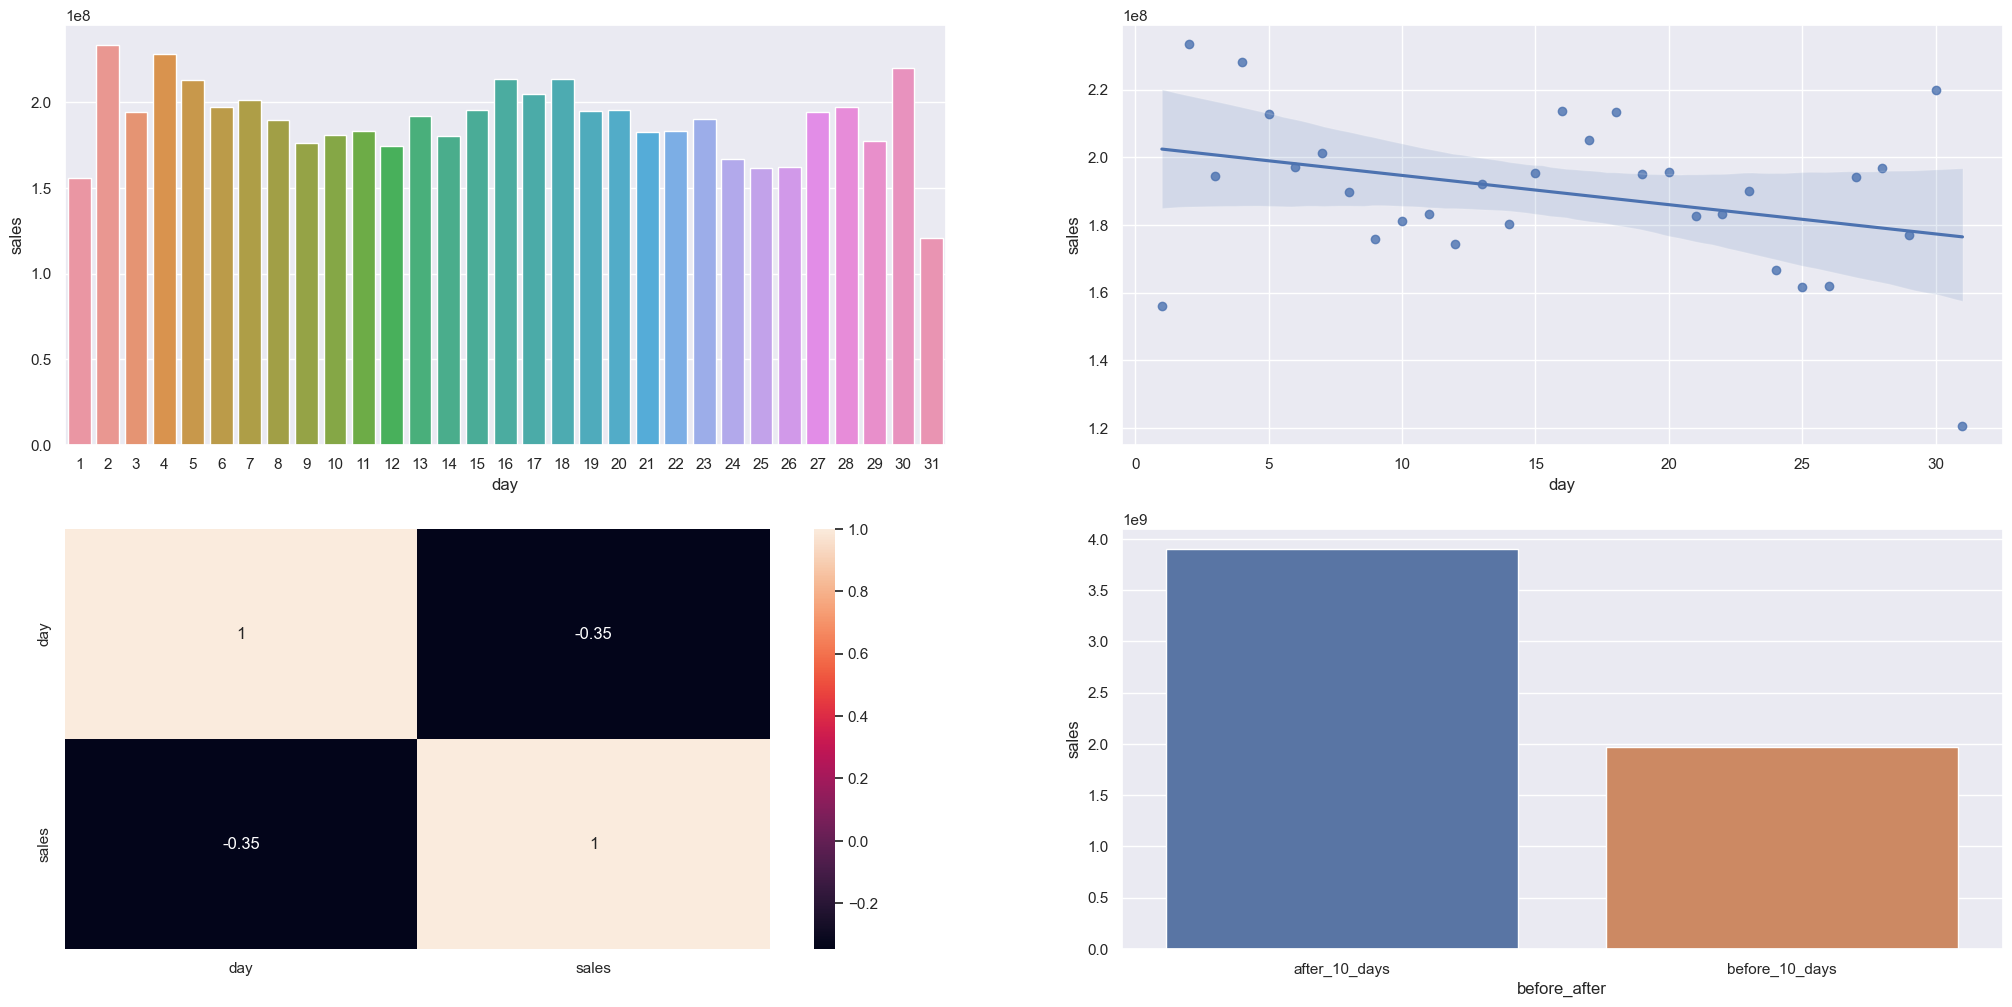

In [40]:
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot( x = 'day', y = 'sales', data = aux)

plt.subplot(2,2,2)
sns.regplot( x = 'day', y = 'sales', data = aux)

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot= True);

aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

aux1 = aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y = 'sales', data = aux1);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana


C:\Users\mathe\AppData\Local\Temp\ipykernel_1872\906611784.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux.corr(method = 'pearson'), annot= True);


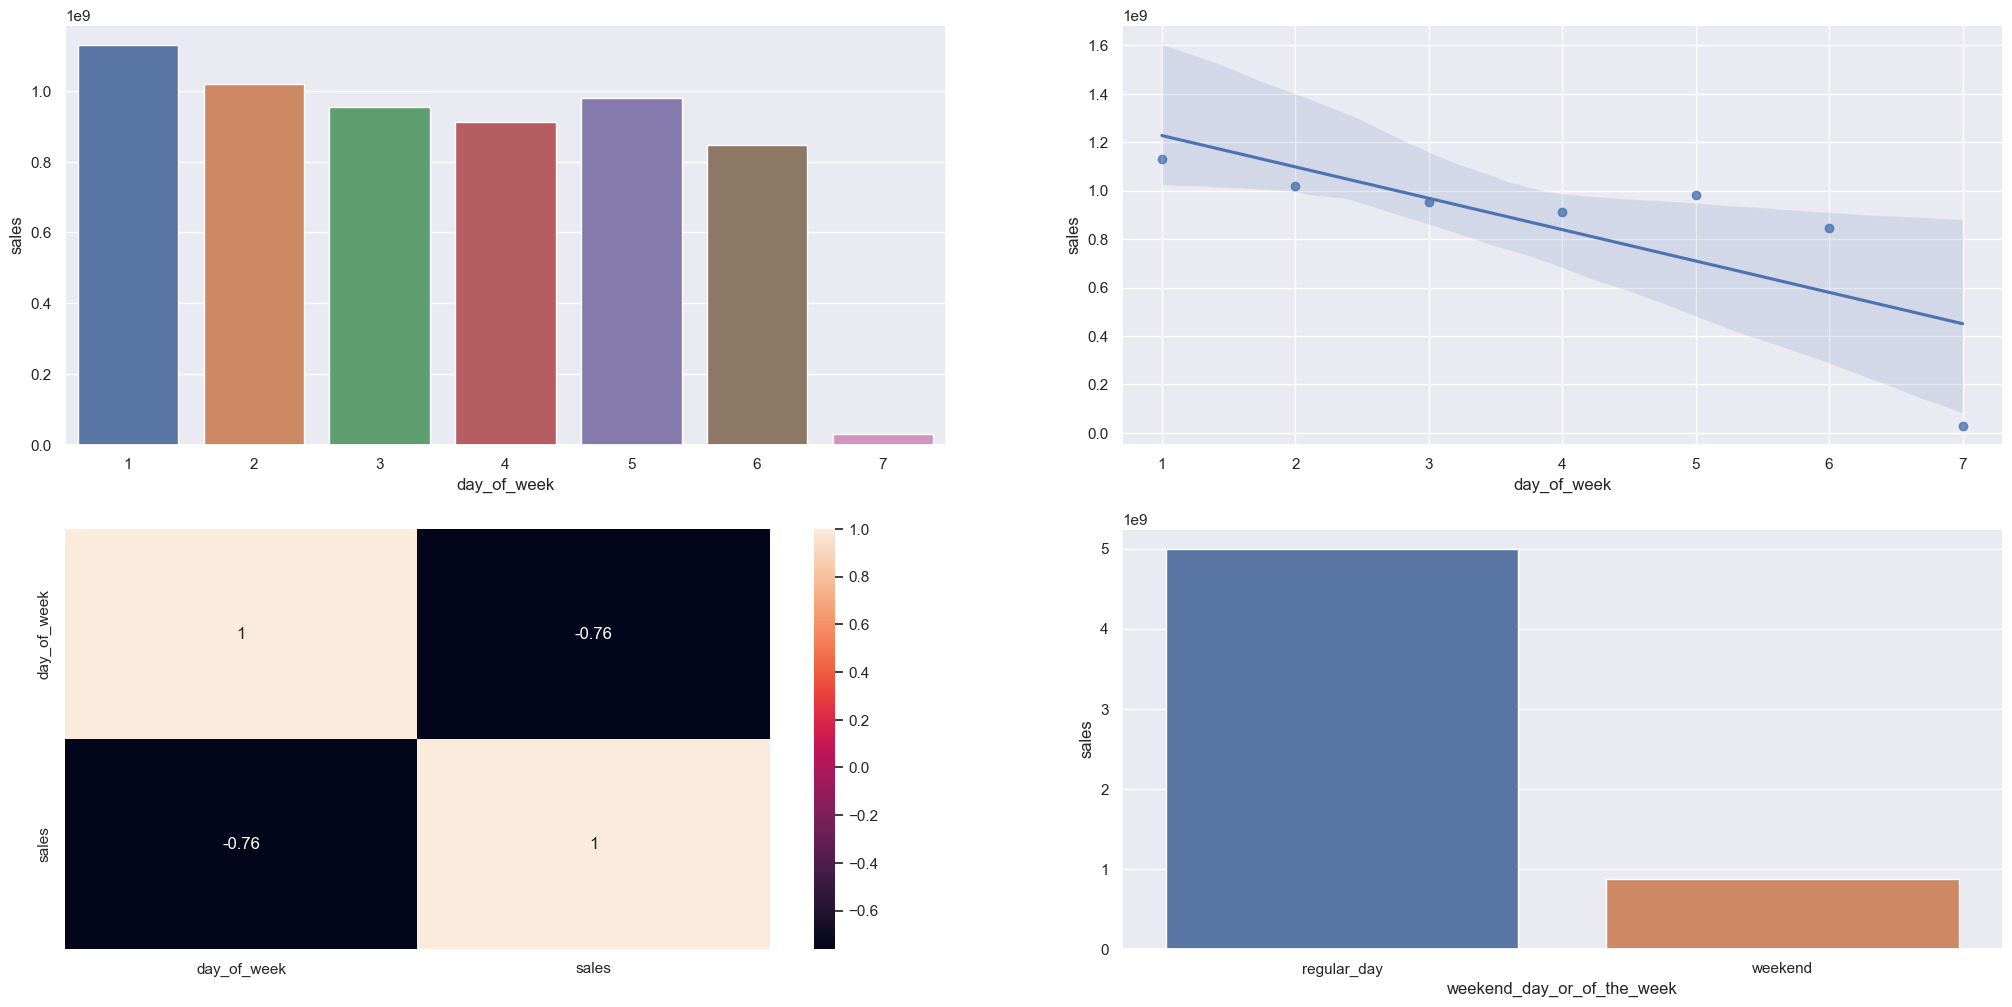

In [41]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()


aux['weekend_day_or_of_the_week'] = aux['day_of_week'].apply(lambda x: 'regular_day' if x < 6 else 'weekend')

aux2 = aux[['weekend_day_or_of_the_week', 'sales']].groupby('weekend_day_or_of_the_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot( x = 'day_of_week', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot= True);

plt.subplot(2,2,4)
sns.barplot( x = 'weekend_day_or_of_the_week', y = 'sales', data = aux2);

### **H12** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos nos feriados escolares 

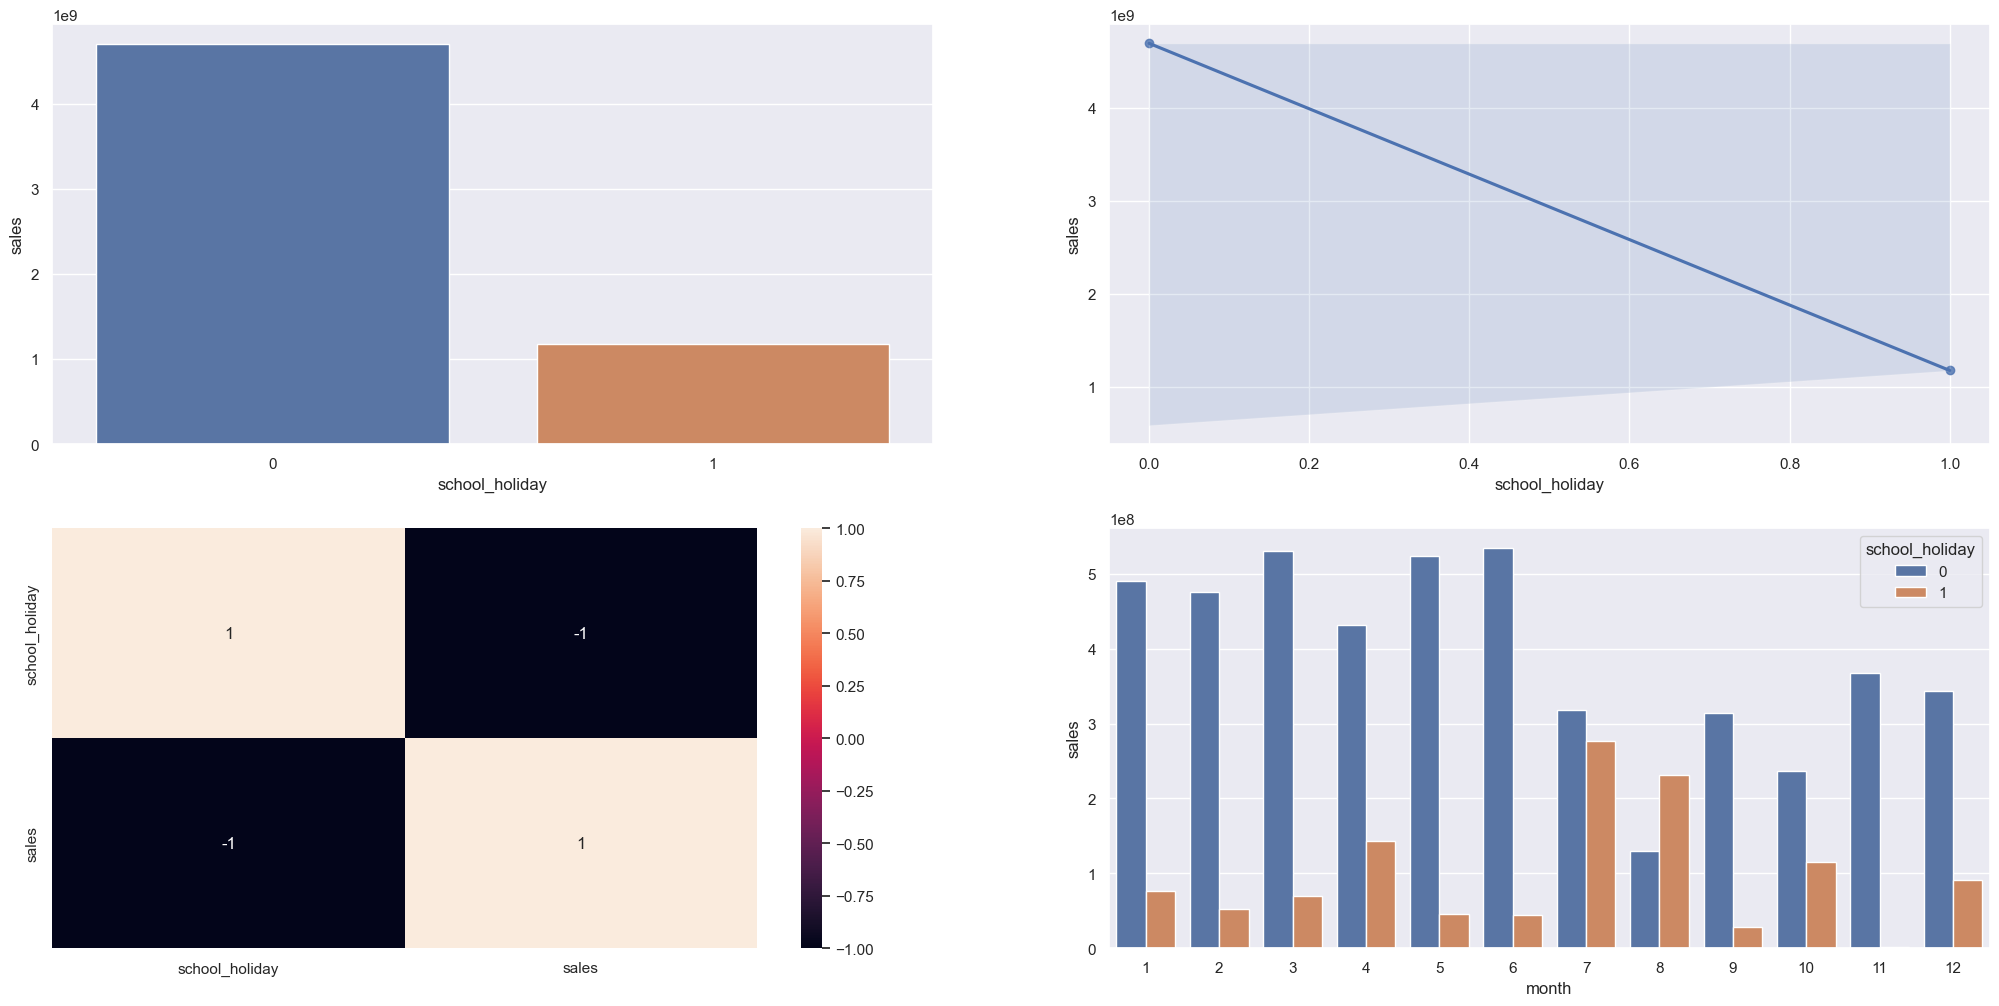

In [42]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()


plt.subplot(2,2,1)
sns.barplot( x = 'school_holiday', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot( x = 'school_holiday', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot= True);



aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,2,4)
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday' ,  data = aux2);

### 4.2.1 Resumo das Hipoteses

In [43]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'], 
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
 ]

print(tabulate(tab , headers= 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 4.3 Análise Multivariada 

#### 4.3.1 Numerical Attributes

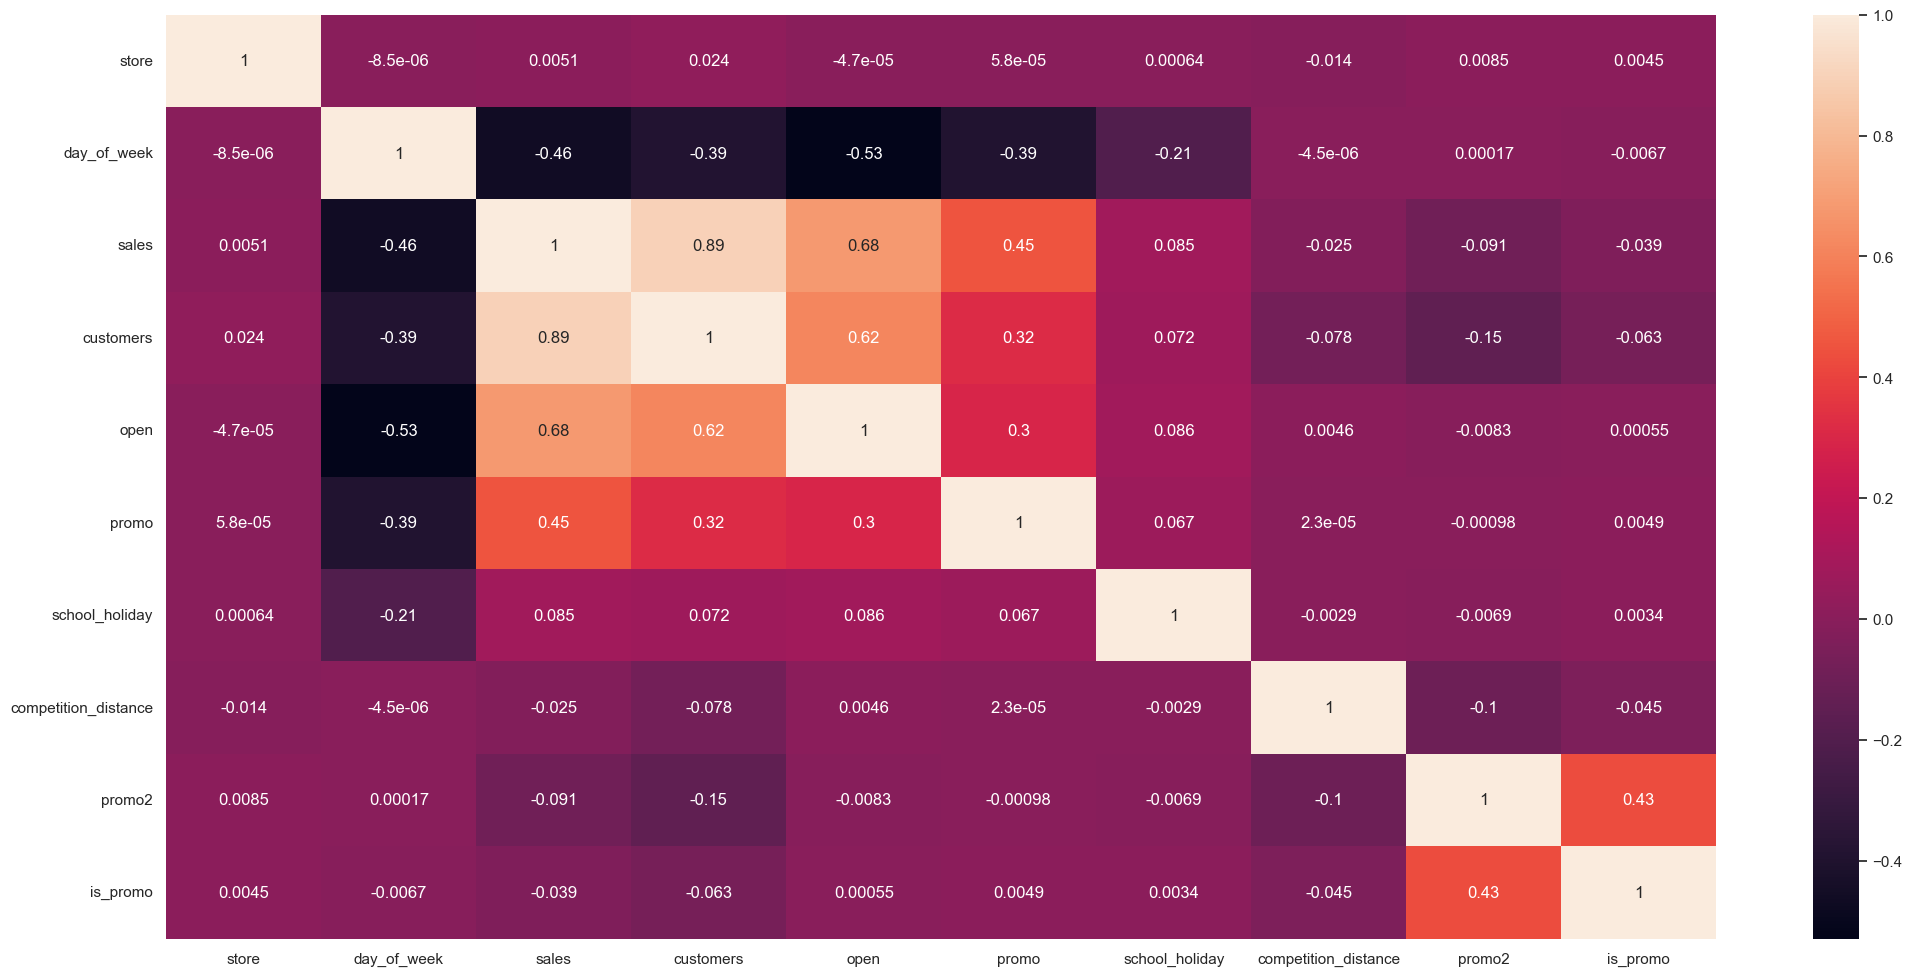

In [44]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

In [45]:
cat = df4.select_dtypes(include= 'object')

In [46]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    result_cramer = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    return result_cramer

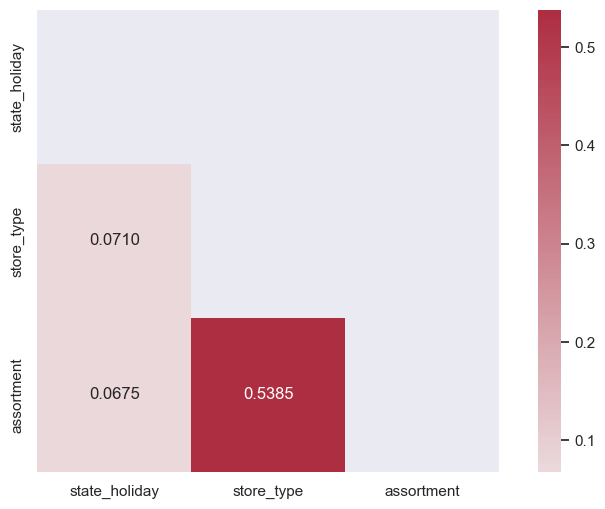

In [47]:
## creating dataframe which will be used for heatmap

cat_list = ['state_holiday', 'store_type' , 'assortment']
cat_dic = {}

for value_x in cat_list:
    for value_y in cat_list:
        v = cramers_v(cat[value_x], cat[value_y])

        if cat_list.index(value_y) == 0:
            cat_dic[value_x] = []
            cat_dic[value_x].append(v)

        else:
             cat_dic[value_x].append(v)

cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace = True)



# Create a mask
mask = np.triu(np.ones_like(cramer_v_table, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(10, 6))
sns.heatmap(cramer_v_table, mask=mask, center=0, annot=True,
            fmt='.4f', square=True, cmap=cmap)

plt.show();

#sns.heatmap(cramer_v_table, annot = True);

## 5.0. PASSO 05 - DATA PREPARATION

In [48]:
df5 = df4.copy()

df5.head()


,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Normalização 

 avaliar quais variaveis serão normalizadas , vou escolher quais variáveis farão parte da normalização 

In [49]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844338 non-null  int64         
 1   day_of_week                   844338 non-null  int64         
 2   date                          844338 non-null  datetime64[ns]
 3   sales                         844338 non-null  int64         
 4   promo                         844338 non-null  int64         
 5   state_holiday                 844338 non-null  object        
 6   school_holiday                844338 non-null  int64         
 7   store_type                    844338 non-null  object        
 8   assortment                    844338 non-null  object        
 9   competition_distance          844338 non-null  float64       
 10  competition_open_since_month  844338 non-null  int32         
 11  competition_

## 5.2 Rescaling

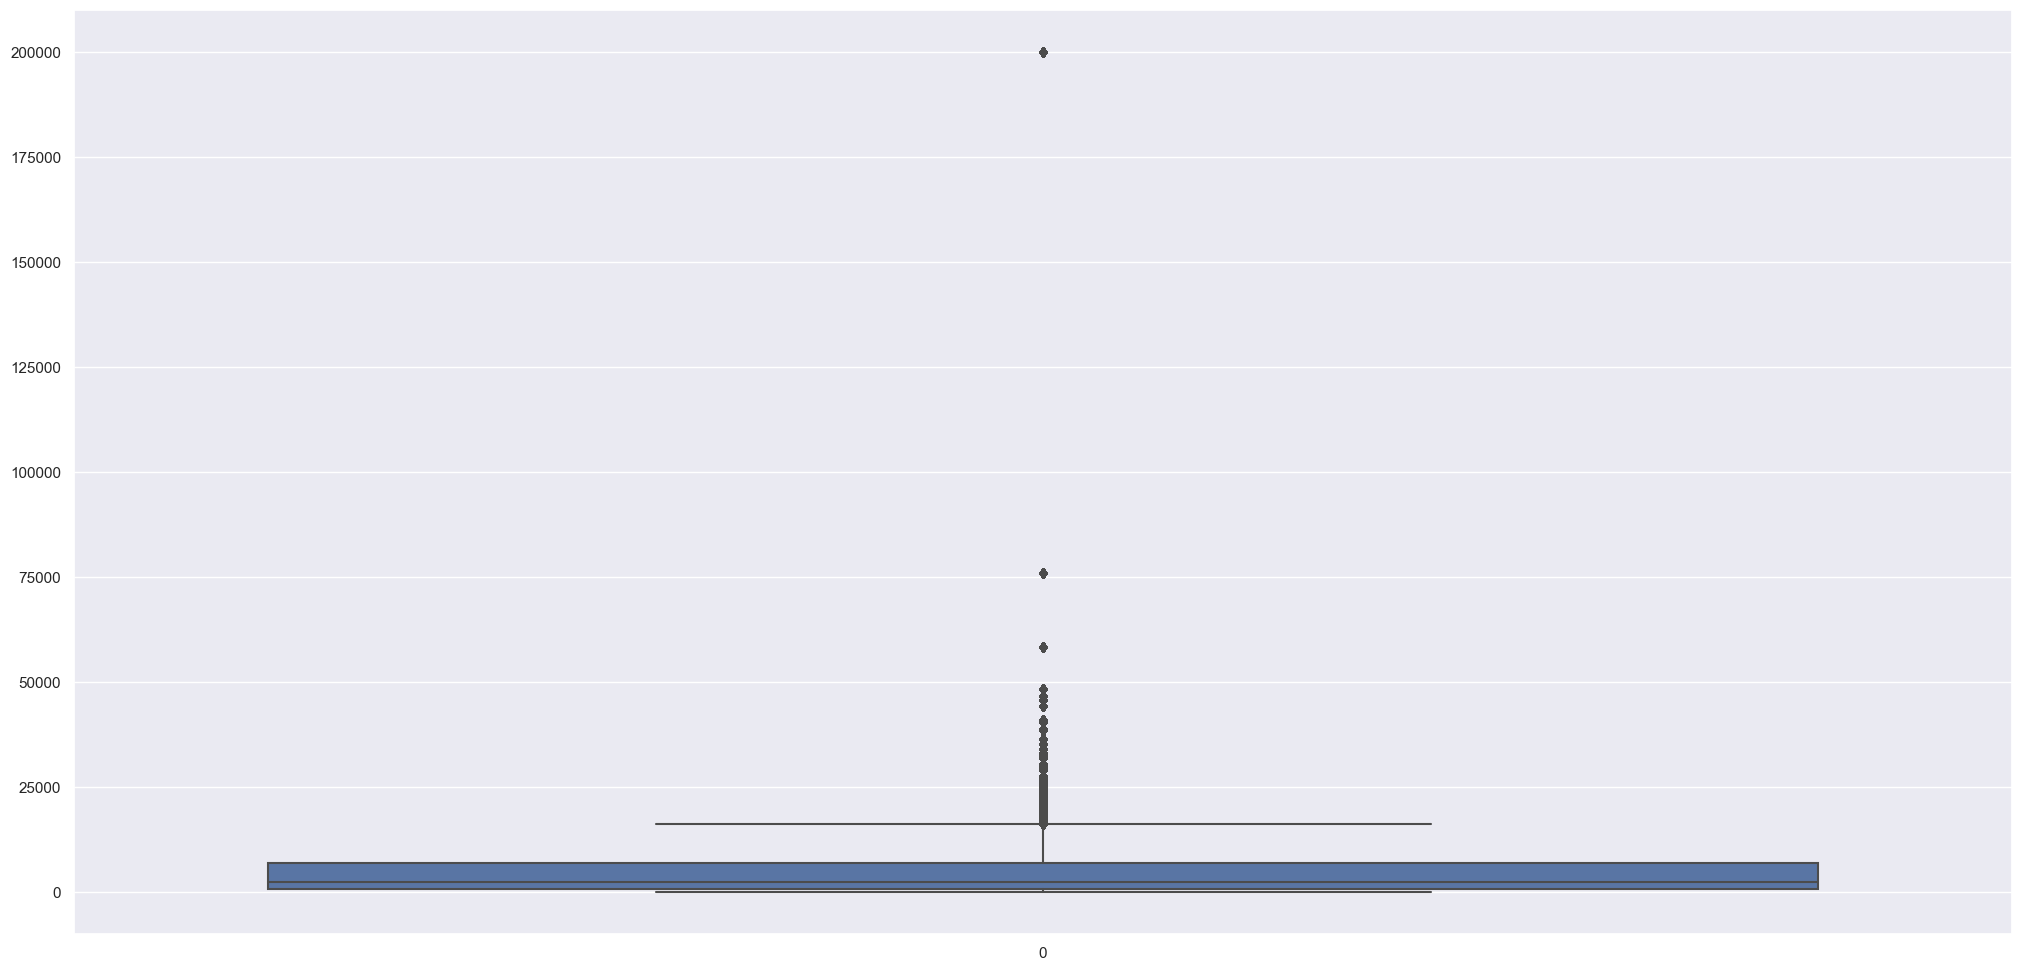

In [50]:

a = df5.select_dtypes(include = ['int64', 'float64', 'int32'])
a.head()

sns.boxplot(df5['competition_distance']);



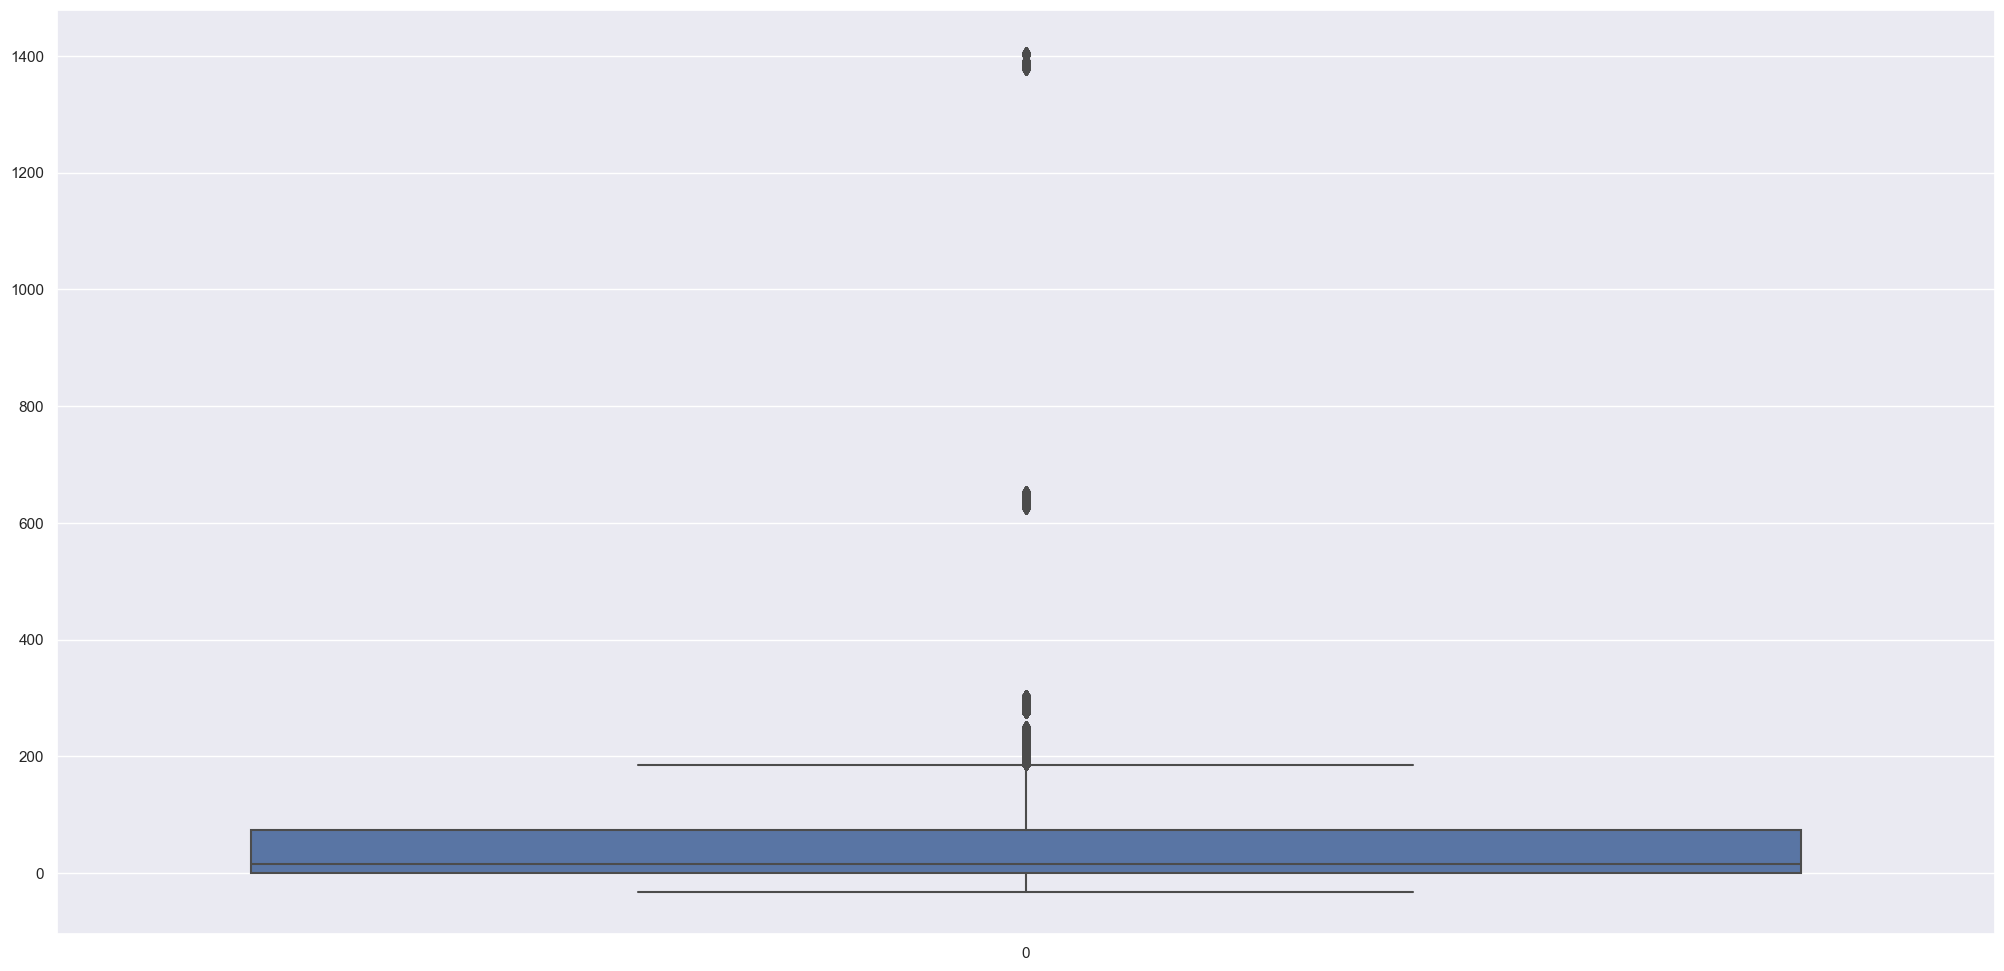

In [51]:
sns.boxplot(df5['competition_time_month']);

In [52]:
## day of week 

rs = RobustScaler()
mms = MinMaxScaler()

## competition distance
df5['competition_distance'] = rs.fit_transform(df5['competition_distance'].values.reshape(-1,1))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5['competition_time_month'].values.reshape(-1,1))

#year 
df5['year'] = mms.fit_transform(df5['year'].values.reshape(-1, 1))
# month 
# day 
# week of year 

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5['promo_time_week'].values.reshape(-1, 1))

In [53]:
df5[['year', 'week_of_year']].head()

,year,week_of_year
0,1.00,31
1,1.00,31
2,1.00,31
3,1.00,31
4,1.00,31


## 5.3 Transformaçao 

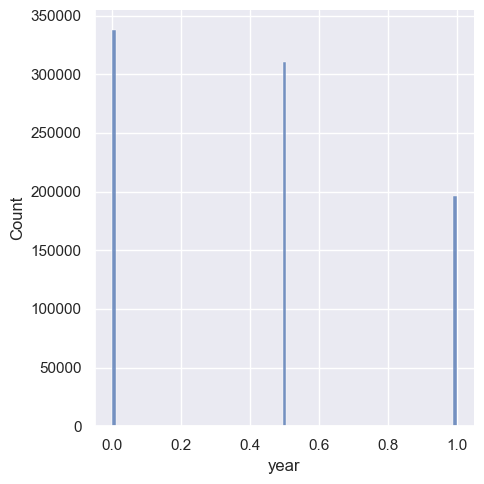

In [54]:
sns.displot(df5['year']);

### 5.3.1 Enconding

In [55]:
# state_holiday - using one hot enconding
df5 = pd.get_dummies(df5, columns= ['state_holiday'])

# store_type using label enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment using ordinal encoding
scale_mapper = {"basic":1, "extra":2, "extended":3}
df5['assortment'] = df5['assortment'].map(scale_mapper)


### 5.3.2 Response Variable Transformation 

In [56]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation 

In [57]:
# month
#df5['month_sen'] = df5['month'].apply(lambda x: np.sin(x * (2 * (np.pi/len(df5['month'].unique())))))


df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

df5['month_sen'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))



# day_of_week 

df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))


# day 

df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

df5['day_sen'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))


# week of year 

df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

df5['week_of_year_sen'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))

In [58]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Easter_holiday,state_holiday_christmas,state_holiday_public_holiday,state_holiday_regular_day,month_cos,month_sen,day_of_week_cos,day_of_week_sen,day_cos,day_sen,week_of_year_cos,week_of_year_sen
0,1,5,2015-07-31,8.57,1,1,2,1,-0.17,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.92,2015-07-27,0.29,0,0,0,1,-0.87,-0.50,-0.22,-0.97,0.98,0.21,-0.82,-0.57
1,2,5,2015-07-31,8.71,1,1,0,1,-0.28,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.05,2010-03-22,0.92,0,0,0,1,-0.87,-0.50,-0.22,-0.97,0.98,0.21,-0.82,-0.57
2,3,5,2015-07-31,9.03,1,1,0,1,1.90,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.20,2011-03-28,0.80,0,0,0,1,-0.87,-0.50,-0.22,-0.97,0.98,0.21,-0.82,-0.57
3,4,5,2015-07-31,9.55,1,1,2,3,-0.28,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.74,2015-07-27,0.29,0,0,0,1,-0.87,-0.50,-0.22,-0.97,0.98,0.21,-0.82,-0.57
4,5,5,2015-07-31,8.48,1,1,0,1,4.45,4,2015,0,31,2015,0,1.00,7,31,31,2015-30,2015-04-01,-0.16,2015-07-27,0.29,0,0,0,1,-0.87,-0.50,-0.22,-0.97,0.98,0.21,-0.82,-0.57


## 6.0 Passo 05 - Data Preparation

In [59]:
df6 = df5.copy()

### 6.1 Split dataframe into training and test dataset

In [60]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [61]:
### separando o conjunto de dados por datas , do ultimo dia até 6 (42 dias)  semanas anteriores serao os dados de teste 
## verifiquei o ultimo dia que é  no caso 31/07/2015
## logo todos os dados entre o ultima dia e 6 semanas anteriores serao dados de teste 
## todos os dados anteriores a data das ultimas 6 semanas serao dados de treino

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]  - datetime.timedelta(days = 42)

Timestamp('2015-06-19 00:00:00')

In [90]:
## training dataset 
x_train = df6.loc[df6['date'] < '2015-06-19', : ]
y_train = x_train['sales']

data_treino_max = x_train['date'].max()
data_treino_min = x_train['date'].min()

print(f'a ultima data dos dados de treino: {data_treino_max}')
print(f'a data mais antiga dos dados de treino: {data_treino_min}')

## test dataset 
x_teste = df6.loc[df6['date'] >= '2015-06-19', : ]
y_test = x_teste['sales']


data_teste_max = x_teste['date'].max()
data_teste_min = x_teste['date'].min()

print(f'a ultima data dos dados de teste: {data_teste_max}')
print(f'a data mais antiga dos dados de teste: {data_teste_min}')


a ultima data dos dados de treino: 2015-06-18 00:00:00
a data mais antiga dos dados de treino: 2013-01-01 00:00:00
a ultima data dos dados de teste: 2015-07-31 00:00:00
a data mais antiga dos dados de teste: 2015-06-19 00:00:00


### 6.2 Boruta as feature selector

In [64]:
## formatando os dados para o boruta 
x_train_n = x_train.drop(['date', 'sales'], axis = 1 ).values
y_train_n = y_train.values.ravel()


forest = RandomForestRegressor(n_jobs=-1)

# # define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state = 42)

feat_selector.fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy(estimator=RandomForestRegressor(n_estimators=73, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x19503A3DC40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x19503A3DC40, verbose=2)

### 6.2.1 Best Features from Boruta


In [84]:
## ranqueando as relevancias das colunas , visualizando quais colunas sao relevantes

cols_selected = feat_selector.support_.tolist()

x_train_fs = x_train.drop(['date', 'sales'], axis = 1 )

### melhores features (colunas)

cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()



### piores features (colunas) , que nao foram selecionadas

cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

### 6.3 Manual Feature Selection

In [92]:
cols_selected_boruta_final = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sen',
 'month_cos',
 'day_of_week_cos',
 'day_of_week_sen',
 'day_cos',
 'day_sen',
 'week_of_year_sen',
 'week_of_year_cos']

 ## columns to add 

feat_to_add = ['date','sales']

## final feature
cols_selected_boruta_final.extend(feat_to_add)

In [93]:
cols_selected_boruta_final

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sen',
 'month_cos',
 'day_of_week_cos',
 'day_of_week_sen',
 'day_cos',
 'day_sen',
 'week_of_year_sen',
 'week_of_year_cos',
 'date',
 'sales']

In [86]:
cols_not_selected_boruta

['is_promo',
 'month_sen',
 'school_holiday',
 'state_holiday_Easter_holiday',
 'state_holiday_christmas',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sen',
 'year']